The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


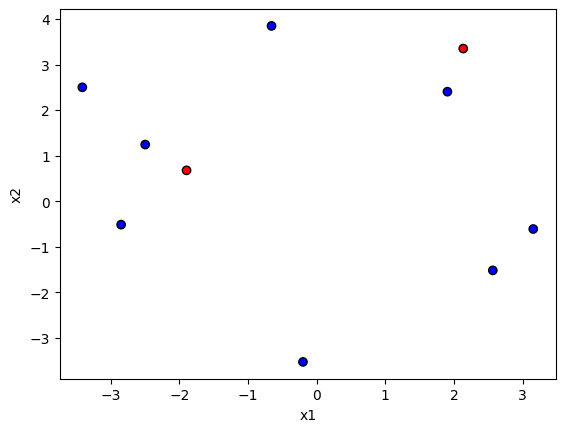

In [40]:
import math
import torch
import numpy as np
import gpytorch
from matplotlib import pyplot as plt

# Define GP Model
from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, MaternKernel

## Clustering and Boundaries
import numpy as np
import matplotlib.pyplot as plt
import alphashape
from shapely.geometry import Point
from sklearn.cluster import DBSCAN
import random


%matplotlib inline
%load_ext autoreload
%autoreload 2


'''
Arbitrary example for classification
The algorithm runs in 2 steps : 2 Class classification(Amorphous vs Crystalline) --> 3 Class classification (Monoclinic vs orthorhombic vs tetragonal)

'''
# Define ground truth function (unknow for optimizer)
def black_box_2C(x):
    x1, x2 = float(x[0]), float(x[1])
    if (-2 <= x1 <= 0 and -1 <= x2 <= +1) or (2 <= x1 <= 4 and 2 <= x2 <= 4):
        return 1
    return 0

# Initial samples
np.random.seed(0)
train_x = -4 + 8 * torch.rand(10, 2)
train_y = torch.tensor([black_box_2C(x) for x in train_x], dtype=torch.long)

plt.scatter(train_x[:, 0], train_x[:, 1], c=train_y, edgecolors='k', cmap="bwr")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()



n_iter = 20
training_iter = 50

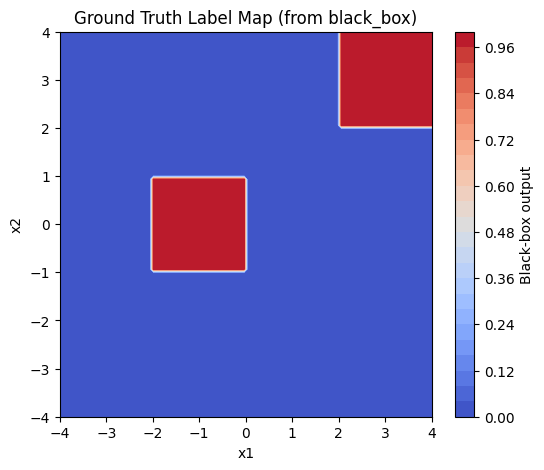

In [41]:
# Specifing the area of optimization 
test_d1 = np.linspace(-4, 4, 100)
test_d2 = np.linspace(-4, 4, 100)

test_x1_2c, test_x2_2c = np.meshgrid(test_d1, test_d2)
test_x1_2c, test_x2_2c = torch.Tensor(test_x1_2c), torch.Tensor(test_x2_2c)

test_x_2c = torch.cat((test_x1_2c.view(-1,1), test_x2_2c.view(-1,1)),dim=1)
test_labels = torch.tensor([black_box_2C(x) for x in test_x_2c], dtype=torch.float)
test_labels = test_labels.view(test_x1_2c.shape)

plt.figure(figsize=(6, 5))
plt.contourf(test_x1_2c.numpy(), test_x2_2c.numpy(), test_labels.numpy(), cmap="coolwarm", levels=25)
plt.colorbar(label="Black-box output")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Ground Truth Label Map (from black_box)")
plt.show()

In [42]:
# Simplest form of GP model, exact inference
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes, nu, lengthscale_prior, lengthscale_constraint, outputscale_prior, outputscale_constraint):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            MaternKernel(
                ard_num_dims = train_x.shape[1],
                batch_shape=torch.Size((num_classes,)),
                nu = nu,
                lengthscale_prior = lengthscale_prior,
                lengthscale_constraint = lengthscale_constraint,
            ),
            batch_shape =torch.Size((num_classes,)),
            outputscale_prior = outputscale_prior,
            outputscale_constraint = outputscale_constraint
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [43]:
# GP to acquisition

def run_sweeps(train_x,train_y,training_iter, nu=0.5, initial_lengthscale = None, lengthscale_prior=None, lengthscale_constraint=None, outputscale_prior=None, outputscale_constraint=None, lr=0.1):
    # Train GP model for each iteration
    likelihood = DirichletClassificationLikelihood(train_y, learn_additional_noise=True)
    model = DirichletGPModel(train_x, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes,
                             nu=nu, lengthscale_prior=lengthscale_prior, lengthscale_constraint=lengthscale_constraint, 
                             outputscale_prior=outputscale_prior, outputscale_constraint=outputscale_constraint, 
                             )
    
    if initial_lengthscale != None:
        model.covar_module.base_kernel.lengthscale = initial_lengthscale

    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, likelihood.transformed_targets).mean()
        loss.backward()
        if i % 5 == 0:
            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                i + 1, training_iter, loss.item(),
                model.covar_module.base_kernel.lengthscale.mean().item(),
                model.likelihood.second_noise_covar.noise.mean().item()
            ))
        optimizer.step()

    # Acquisition function optimization
    model.eval()
    likelihood.eval()
    
    return model,likelihood

def acquisition(model, test_x, func, var_space = None, num_samples=256):
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_dist = model(test_x)  # MultitaskMultivariateNormal

        # Sampling latent function
        f_samples = test_dist.sample(torch.Size([num_samples]))

        # Normalizing the class probabilities
        prob_samples = torch.softmax(f_samples, dim=1) 

        # Average over samples → [num_classes, num_points]
        probs = prob_samples.mean(dim=0) 
        var = prob_samples.var(dim=0).sum(dim=0)
        
        if func == "most_unprobable":
        # Uncertainty: distance from 0.5
            uncertainty = 1 - probs.max(dim=0).values
        elif func == "entropy":
            uncertainty = -torch.sum(probs * torch.log(probs + 1e-10), dim=0) 
        elif func == "variance":
            if var_space == "prob":
                uncertainty = prob_samples.var(dim=0, correction = 0).sum(dim=0)
            elif var_space == "latent":
                uncertainty = f_samples.var(dim=0, correction = 0).sum(dim=0)
        

        query_idx = torch.argmax(uncertainty)

        total_entropy = -torch.sum(probs * torch.log(probs + 1e-10), dim=0).mean()
        total_entropy = float(total_entropy.sum())

    return probs, var, uncertainty, query_idx, total_entropy

# 2C Classification with GPC
def C2_GPC(n_iter, train_x_2c, train_y_2c, test_x_2c, training_iter, func="most_unprobable", lr=0.1, num_samples=256):
    for iteration in range(n_iter):

        model, likelihood = run_sweeps(train_x_2c, train_y_2c, training_iter, lr=lr)
        probs, uncertainty, query_idx = acquisition(model, test_x_2c, func, num_samples)

        x_next = test_x_2c[query_idx]
        y_next = torch.tensor([black_box_2C(x_next)], dtype=torch.long)

        # Append Data
        train_x_2c = torch.cat([train_x_2c, x_next.unsqueeze(0)], dim=0)
        train_y_2c = torch.cat([train_y_2c, y_next], dim=0)

        # Visualization
        plt.figure(figsize=(6, 5))
        contour = plt.contourf(
            test_x1_2c.numpy(), test_x2_2c.numpy(),
            probs[1, :].view(100, 100).numpy(), cmap="bwr", levels=100, alpha=0.6
        )
        plt.colorbar(contour, label="Predicted Probability (Class 1)")
        plt.scatter(train_x_2c[:, 0], train_x_2c[:, 1], c=train_y_2c, cmap="bwr", edgecolors='k', label="Train points")
        plt.scatter(x_next[0].item(), x_next[1].item(), c='gold', edgecolors='black', s=100, marker='*', label="Next sample")
        plt.title(f"Iteration {iteration+1}")
        plt.xlabel("x1")
        plt.ylabel("x2")
        plt.legend()
        plt.tight_layout()
        plt.show()
    return likelihood, probs, uncertainty, train_x_2c, train_y_2c

## C2 CLASSIFICATION

Iter 1/50 - Loss: 3.039   lengthscale: 1.000   noise: 0.693
Iter 6/50 - Loss: 2.778   lengthscale: 1.085   noise: 0.723
Iter 11/50 - Loss: 2.612   lengthscale: 1.317   noise: 0.804
Iter 16/50 - Loss: 2.527   lengthscale: 1.631   noise: 0.931
Iter 21/50 - Loss: 2.467   lengthscale: 1.935   noise: 1.096
Iter 26/50 - Loss: 2.417   lengthscale: 2.177   noise: 1.285
Iter 31/50 - Loss: 2.382   lengthscale: 2.352   noise: 1.483
Iter 36/50 - Loss: 2.351   lengthscale: 2.477   noise: 1.681
Iter 41/50 - Loss: 2.330   lengthscale: 2.568   noise: 1.868
Iter 46/50 - Loss: 2.313   lengthscale: 2.637   noise: 2.039


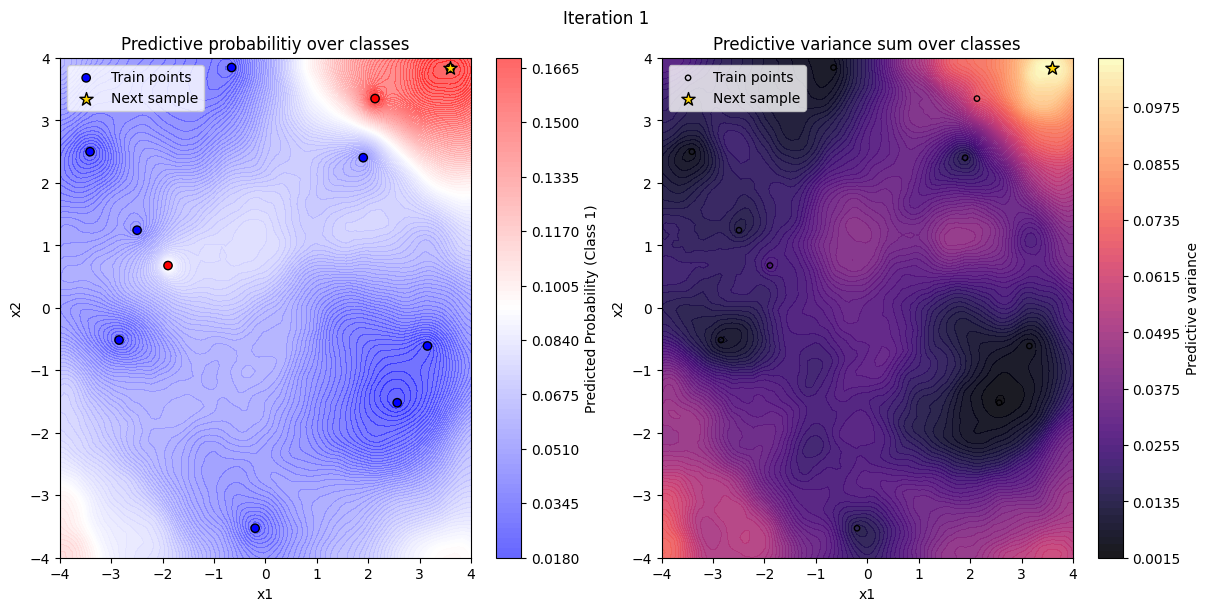

Iter 1/50 - Loss: 2.865   lengthscale: 2.693   noise: 0.693
Iter 6/50 - Loss: 2.726   lengthscale: 2.835   noise: 0.723
Iter 11/50 - Loss: 2.628   lengthscale: 2.821   noise: 0.807
Iter 16/50 - Loss: 2.578   lengthscale: 2.826   noise: 0.930
Iter 21/50 - Loss: 2.560   lengthscale: 2.703   noise: 1.083
Iter 26/50 - Loss: 2.534   lengthscale: 2.551   noise: 1.246
Iter 31/50 - Loss: 2.512   lengthscale: 2.325   noise: 1.394
Iter 36/50 - Loss: 2.499   lengthscale: 1.932   noise: 1.511
Iter 41/50 - Loss: 2.482   lengthscale: 1.491   noise: 1.590
Iter 46/50 - Loss: 2.461   lengthscale: 1.113   noise: 1.632


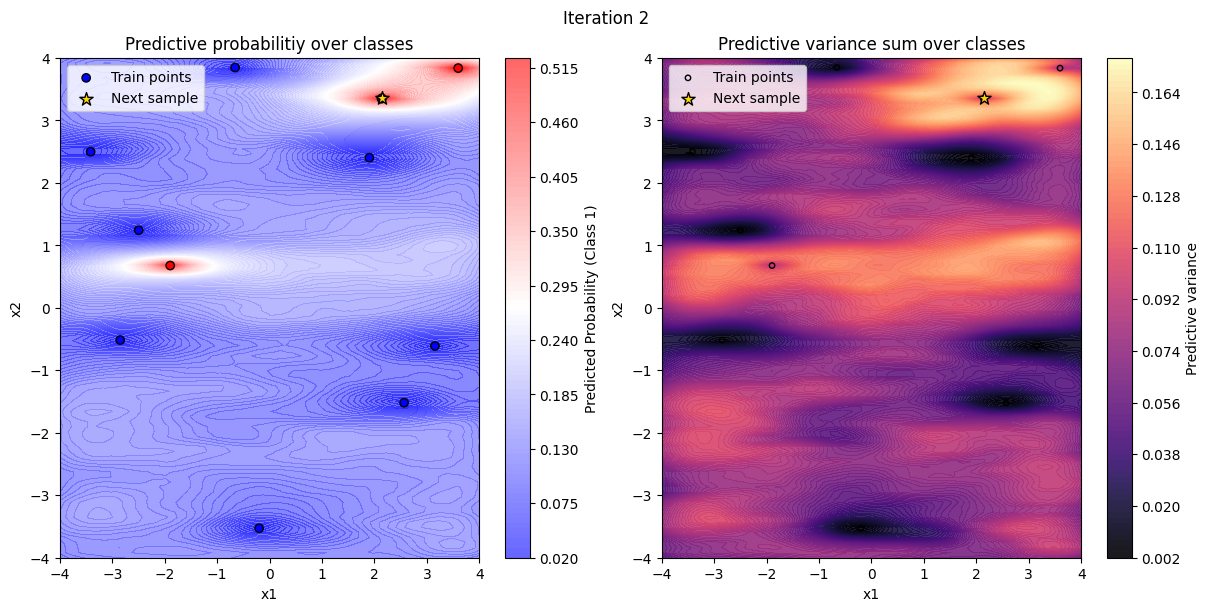

total_entropy - previous_total_entropy = 0.5973646371209144
Iter 1/50 - Loss: 3.007   lengthscale: 0.829   noise: 0.693
Iter 6/50 - Loss: 2.790   lengthscale: 1.196   noise: 0.720
Iter 11/50 - Loss: 2.649   lengthscale: 1.639   noise: 0.778
Iter 16/50 - Loss: 2.572   lengthscale: 1.982   noise: 0.829
Iter 21/50 - Loss: 2.545   lengthscale: 2.228   noise: 0.867
Iter 26/50 - Loss: 2.531   lengthscale: 2.426   noise: 0.913
Iter 31/50 - Loss: 2.519   lengthscale: 2.562   noise: 0.984
Iter 36/50 - Loss: 2.512   lengthscale: 2.601   noise: 1.080
Iter 41/50 - Loss: 2.506   lengthscale: 2.551   noise: 1.190
Iter 46/50 - Loss: 2.500   lengthscale: 2.464   noise: 1.292


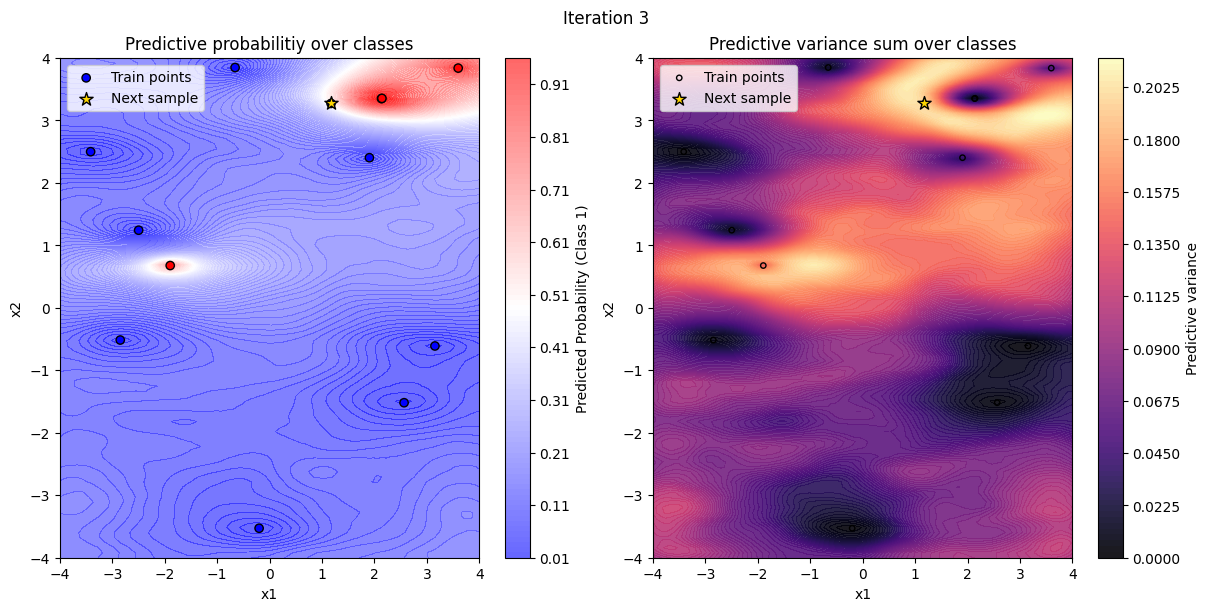

total_entropy - previous_total_entropy = 0.07623546845605321
Iter 1/50 - Loss: 2.809   lengthscale: 2.373   noise: 0.693
Iter 6/50 - Loss: 2.671   lengthscale: 2.231   noise: 0.724
Iter 11/50 - Loss: 2.593   lengthscale: 2.202   noise: 0.809
Iter 16/50 - Loss: 2.557   lengthscale: 2.200   noise: 0.937
Iter 21/50 - Loss: 2.534   lengthscale: 2.107   noise: 1.087
Iter 26/50 - Loss: 2.515   lengthscale: 1.941   noise: 1.233
Iter 31/50 - Loss: 2.502   lengthscale: 1.736   noise: 1.357
Iter 36/50 - Loss: 2.490   lengthscale: 1.483   noise: 1.447
Iter 41/50 - Loss: 2.479   lengthscale: 1.191   noise: 1.493
Iter 46/50 - Loss: 2.467   lengthscale: 0.910   noise: 1.487


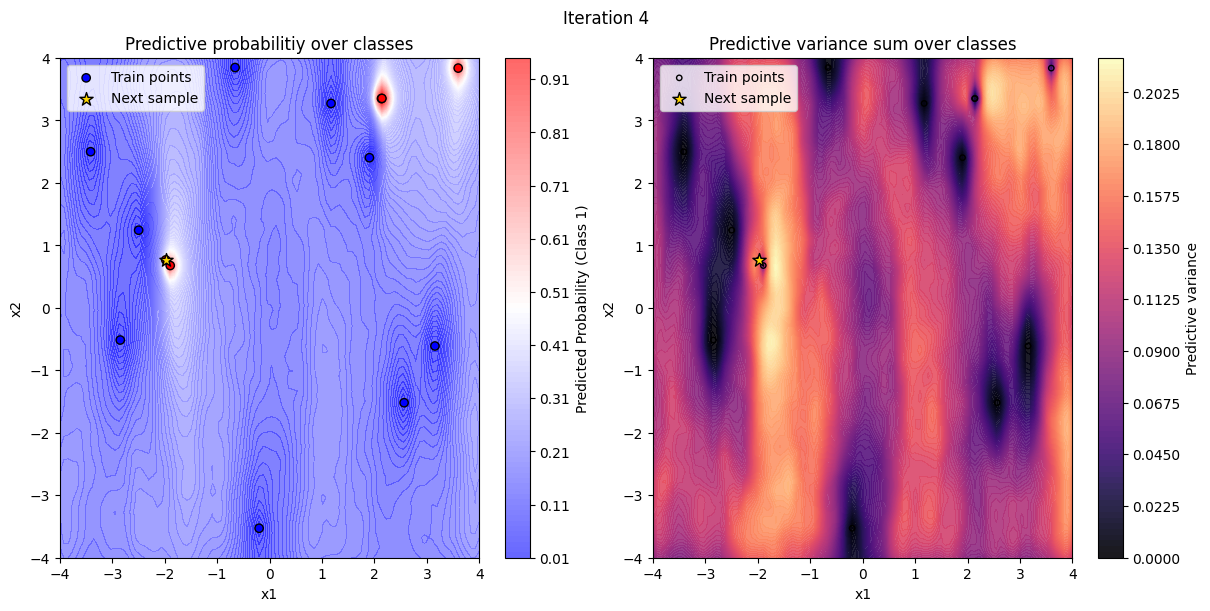

total_entropy - previous_total_entropy = 0.0998563207608621
Iter 1/50 - Loss: 2.939   lengthscale: 0.688   noise: 0.693
Iter 6/50 - Loss: 2.735   lengthscale: 0.978   noise: 0.717
Iter 11/50 - Loss: 2.619   lengthscale: 1.331   noise: 0.742
Iter 16/50 - Loss: 2.562   lengthscale: 1.662   noise: 0.717
Iter 21/50 - Loss: 2.540   lengthscale: 1.852   noise: 0.653
Iter 26/50 - Loss: 2.529   lengthscale: 1.839   noise: 0.573
Iter 31/50 - Loss: 2.513   lengthscale: 1.669   noise: 0.480
Iter 36/50 - Loss: 2.496   lengthscale: 1.410   noise: 0.370
Iter 41/50 - Loss: 2.477   lengthscale: 1.133   noise: 0.256
Iter 46/50 - Loss: 2.458   lengthscale: 0.895   noise: 0.163


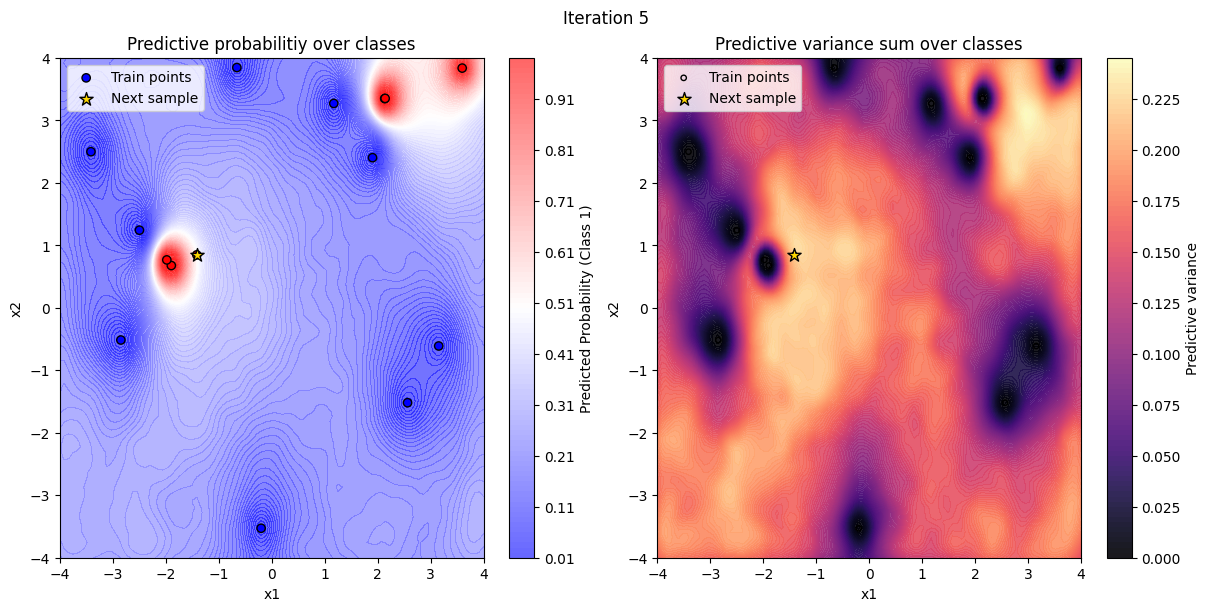

total_entropy - previous_total_entropy = 0.1334895316663247
Iter 1/50 - Loss: 2.893   lengthscale: 0.722   noise: 0.693
Iter 6/50 - Loss: 2.698   lengthscale: 1.057   noise: 0.707
Iter 11/50 - Loss: 2.603   lengthscale: 1.462   noise: 0.656
Iter 16/50 - Loss: 2.560   lengthscale: 1.780   noise: 0.534
Iter 21/50 - Loss: 2.537   lengthscale: 1.897   noise: 0.400
Iter 26/50 - Loss: 2.520   lengthscale: 1.810   noise: 0.279
Iter 31/50 - Loss: 2.501   lengthscale: 1.578   noise: 0.183
Iter 36/50 - Loss: 2.480   lengthscale: 1.300   noise: 0.117
Iter 41/50 - Loss: 2.461   lengthscale: 1.059   noise: 0.077
Iter 46/50 - Loss: 2.448   lengthscale: 0.885   noise: 0.053


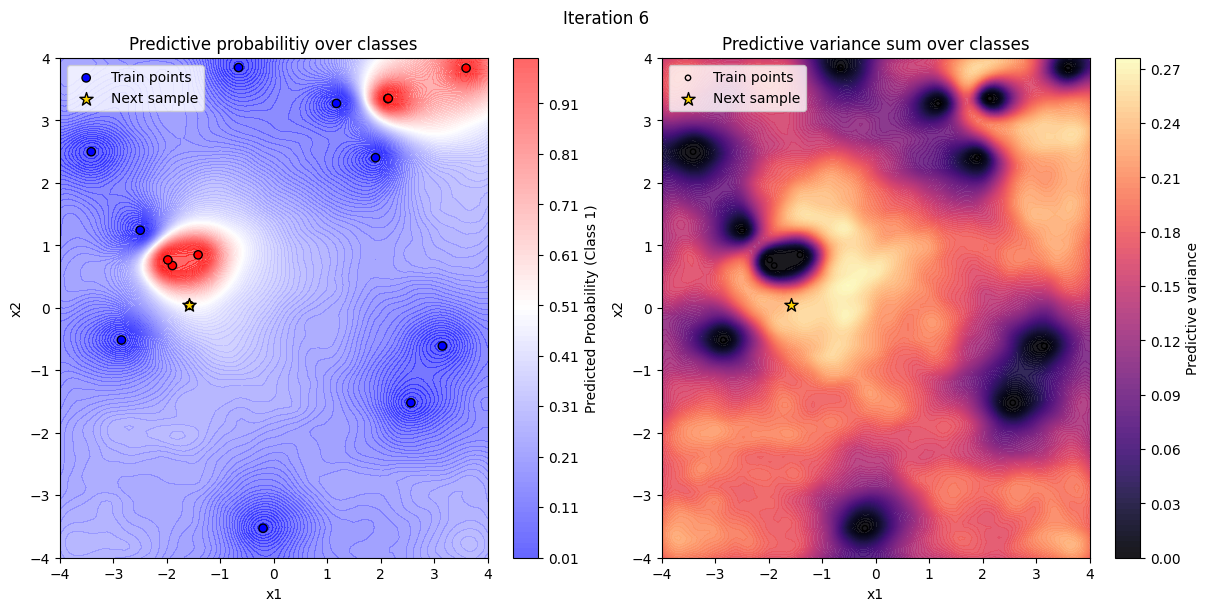

total_entropy - previous_total_entropy = 0.010112567596298616
Iter 1/50 - Loss: 2.871   lengthscale: 0.772   noise: 0.693
Iter 6/50 - Loss: 2.678   lengthscale: 1.144   noise: 0.682
Iter 11/50 - Loss: 2.589   lengthscale: 1.593   noise: 0.538
Iter 16/50 - Loss: 2.552   lengthscale: 1.901   noise: 0.378
Iter 21/50 - Loss: 2.525   lengthscale: 1.953   noise: 0.254
Iter 26/50 - Loss: 2.501   lengthscale: 1.839   noise: 0.166
Iter 31/50 - Loss: 2.482   lengthscale: 1.670   noise: 0.110
Iter 36/50 - Loss: 2.469   lengthscale: 1.508   noise: 0.075
Iter 41/50 - Loss: 2.458   lengthscale: 1.368   noise: 0.054
Iter 46/50 - Loss: 2.450   lengthscale: 1.250   noise: 0.042


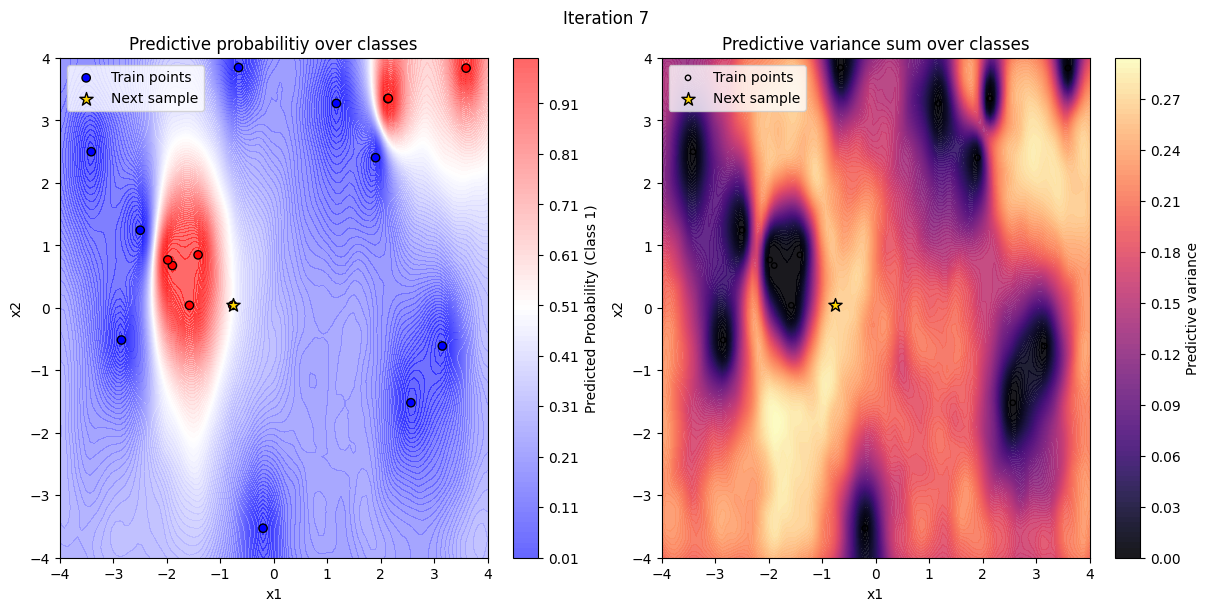

total_entropy - previous_total_entropy = 0.02715184303390488
Iter 1/50 - Loss: 2.822   lengthscale: 1.152   noise: 0.693
Iter 6/50 - Loss: 2.648   lengthscale: 1.645   noise: 0.567
Iter 11/50 - Loss: 2.569   lengthscale: 2.015   noise: 0.387
Iter 16/50 - Loss: 2.531   lengthscale: 2.085   noise: 0.253
Iter 21/50 - Loss: 2.508   lengthscale: 1.947   noise: 0.164
Iter 26/50 - Loss: 2.489   lengthscale: 1.711   noise: 0.109
Iter 31/50 - Loss: 2.475   lengthscale: 1.477   noise: 0.075
Iter 36/50 - Loss: 2.463   lengthscale: 1.298   noise: 0.055
Iter 41/50 - Loss: 2.453   lengthscale: 1.185   noise: 0.042
Iter 46/50 - Loss: 2.444   lengthscale: 1.123   noise: 0.033


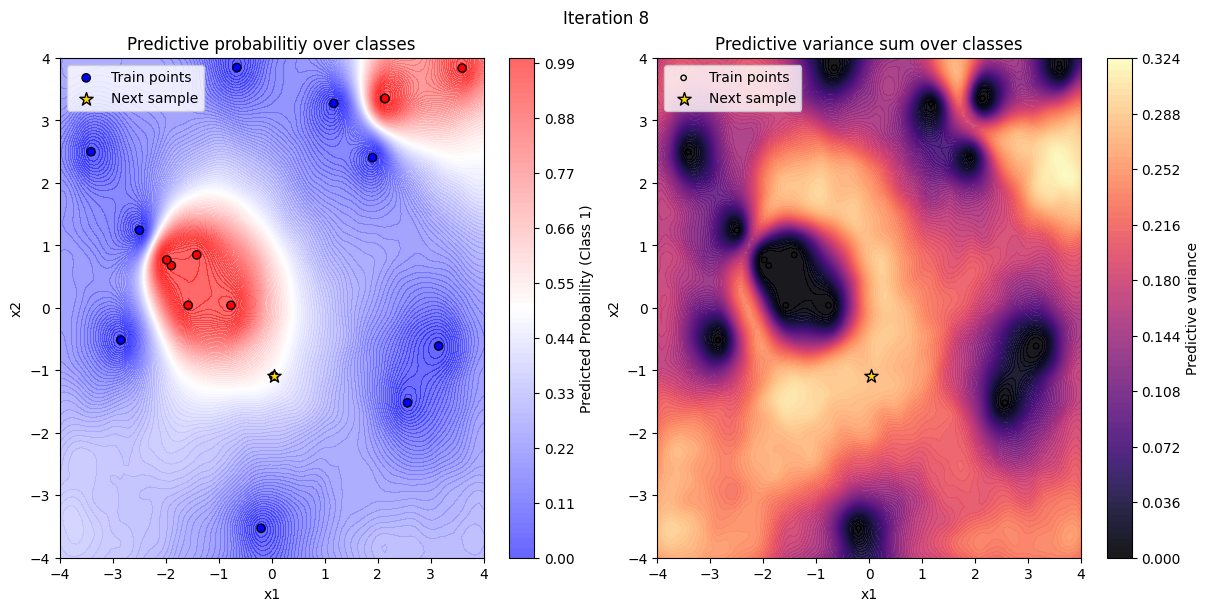

total_entropy - previous_total_entropy = 0.0050971744610301935
Iter 1/50 - Loss: 2.787   lengthscale: 1.091   noise: 0.693
Iter 6/50 - Loss: 2.630   lengthscale: 1.596   noise: 0.617
Iter 11/50 - Loss: 2.568   lengthscale: 2.009   noise: 0.440
Iter 16/50 - Loss: 2.536   lengthscale: 2.154   noise: 0.297
Iter 21/50 - Loss: 2.514   lengthscale: 2.076   noise: 0.197
Iter 26/50 - Loss: 2.496   lengthscale: 1.873   noise: 0.131
Iter 31/50 - Loss: 2.481   lengthscale: 1.637   noise: 0.089
Iter 36/50 - Loss: 2.467   lengthscale: 1.426   noise: 0.064
Iter 41/50 - Loss: 2.456   lengthscale: 1.268   noise: 0.048
Iter 46/50 - Loss: 2.448   lengthscale: 1.158   noise: 0.038


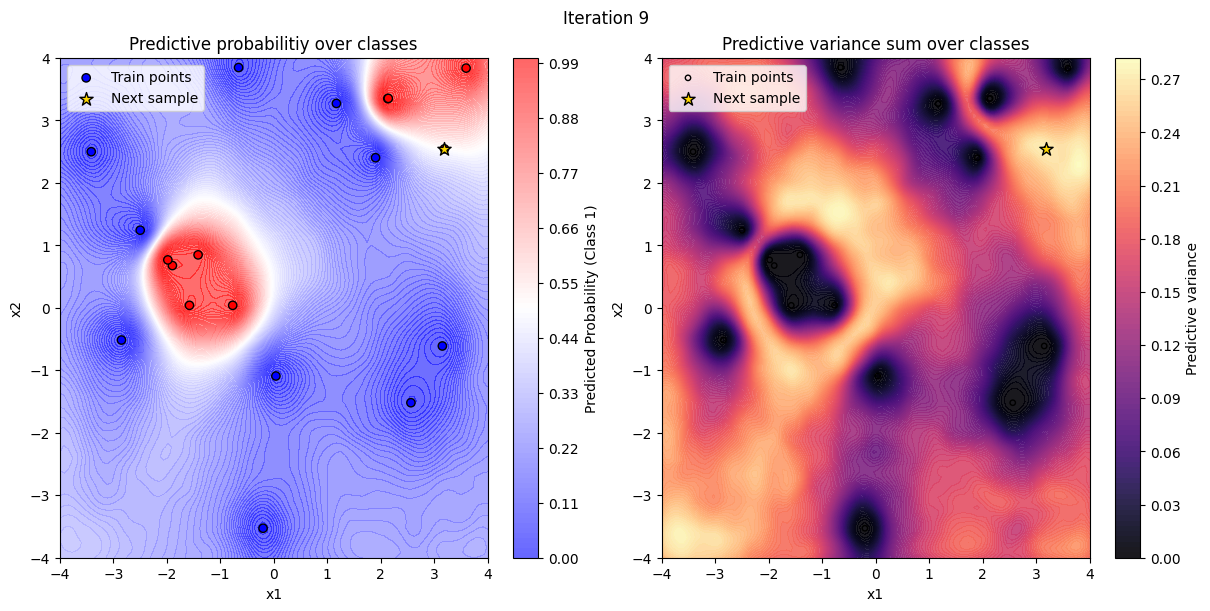

total_entropy - previous_total_entropy = 0.06612416580944183
Iter 1/50 - Loss: 2.789   lengthscale: 1.080   noise: 0.693
Iter 6/50 - Loss: 2.626   lengthscale: 1.580   noise: 0.530
Iter 11/50 - Loss: 2.561   lengthscale: 2.051   noise: 0.357
Iter 16/50 - Loss: 2.529   lengthscale: 2.277   noise: 0.235
Iter 21/50 - Loss: 2.506   lengthscale: 2.273   noise: 0.155
Iter 26/50 - Loss: 2.490   lengthscale: 2.136   noise: 0.104
Iter 31/50 - Loss: 2.477   lengthscale: 1.944   noise: 0.072
Iter 36/50 - Loss: 2.467   lengthscale: 1.749   noise: 0.052
Iter 41/50 - Loss: 2.459   lengthscale: 1.580   noise: 0.040
Iter 46/50 - Loss: 2.453   lengthscale: 1.447   noise: 0.032


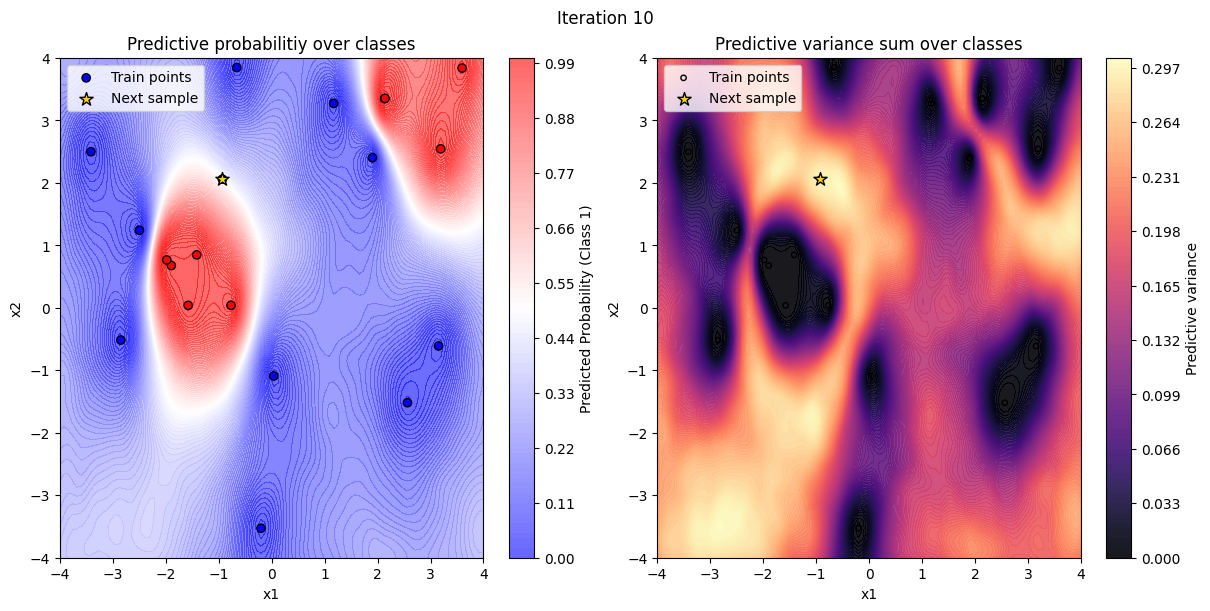

total_entropy - previous_total_entropy = 0.0026530432942421522


In [ ]:
from gpytorch.priors import GammaPrior, LogNormalPrior
from gpytorch.constraints import GreaterThan, Positive, Interval

# func="variance"
# var_space = "prob"

func = "most_unprobable"
var_space = None
lr = 0.1
num_samples = 256

n_iter  = 20 
## iteration for 2class optimization
train_x_2c = train_x
train_y_2c = train_y

# nu = 0.5 

initial_lengthscale = torch.tensor([
    [1,1], # class 1
    [1,1] # class 2
    ])

# lengthscale_constraint = Interval(0.2,5)
# outputscale_constraint = Interval(0.1,10)


nu = 0.5
# initial_lengthscale = None
lengthscale_constraint = Interval(0.1,10)
outputscale_constraint = Interval(0.1,10)

previous_total_entropy = None

N = 0

for iteration in range(n_iter):
    model, likelihood = run_sweeps(train_x_2c, train_y_2c, training_iter, 
                                   lr=lr, nu=nu, initial_lengthscale=initial_lengthscale, lengthscale_constraint=lengthscale_constraint, 
                                    outputscale_constraint=outputscale_constraint)
    
    # model, likelihood = run_sweeps(train_x_2c, train_y_2c, training_iter, lr=lr)
    probs, var, uncertainty, query_idx, total_entropy = acquisition(model, test_x_2c, func, var_space, num_samples)

    x_next = test_x_2c[query_idx]
    y_next = torch.tensor([black_box_2C(x_next)], dtype=torch.long)

    # Append Data
    train_x_2c = torch.cat([train_x_2c, x_next.unsqueeze(0)], dim=0)
    train_y_2c = torch.cat([train_y_2c, y_next], dim=0)

    # Visualization
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=False, sharey=False,
                            constrained_layout=True)

    contour_prob = axs[0].contourf(
        test_x1_2c.numpy(), test_x2_2c.numpy(),
        probs[1, :].view(100, 100).numpy(), cmap="bwr", levels=100, alpha=0.6
    )
    fig.suptitle(f"Iteration {iteration+1}")
    axs[0].set_title("Predictive probabilitiy over classes")
    axs[0].scatter(train_x_2c[:, 0], train_x_2c[:, 1], c=train_y_2c, cmap="bwr", edgecolors='k', label="Train points")
    axs[0].scatter(x_next[0].item(), x_next[1].item(), c='gold', edgecolors='black', s=100, marker='*', label="Next sample")
    axs[0].set_xlabel("x1")
    axs[0].set_ylabel("x2")
    axs[0].figure.colorbar(contour_prob, ax=axs[0], label="Predicted Probability (Class 1)")

    axs[0].legend()
    
    contour_var = axs[1].contourf(
    test_x1_2c.numpy(), test_x2_2c.numpy(),
    var.view(100, 100).numpy(), cmap="magma", levels=100, alpha=0.9
    )
    axs[1].set_title("Predictive variance sum over classes")
    axs[1].set_xlabel("x1"); axs[1].set_ylabel("x2")
    axs[1].scatter(train_x_2c[:, 0], train_x_2c[:, 1], c='none', edgecolors='k', s=15, label="Train points")
    axs[1].scatter(x_next[0].item(), x_next[1].item(), c='gold', edgecolors='black', s=100, marker='*', label="Next sample")
    axs[1].set_xlabel("x1")
    axs[1].set_ylabel("x2")
    axs[1].figure.colorbar(contour_var, ax=axs[1], label="Predictive variance")
    axs[1].legend()

    plt.show()
    
    if previous_total_entropy != None:
        diff = abs(total_entropy - previous_total_entropy) / previous_total_entropy
        print(f"total_entropy - previous_total_entropy = {diff}")
        if  diff < 0.1 : 
            N = N+1
        else : 
            N= 0
        if N > 4 :
            break

    final_lengthscale = model.covar_module.base_kernel.lengthscale.tolist()
    final_outputscale = model.covar_module.outputscale.tolist()
    previous_total_entropy = total_entropy
    initial_lengthscale = final_lengthscale
    initial_outputscale = final_outputscale        
    
train_x_2c_o = train_x_2c
train_y_2c_o = train_y_2c

In [25]:
probs.shape

torch.Size([2, 10000])

In [60]:
# Define boundaries for 2C classification
def define_boundaries(ax, probs, test_x_2c):
    test_mask = probs[1,:] >= 0.5
    test_x1_selected = test_x_2c[test_mask][:, 0]
    test_x2_selected = test_x_2c[test_mask][:, 1]

    points = np.vstack([test_x1_selected, test_x2_selected]).T

    ## Cluster the points using DBSCAN
    clustering = DBSCAN(eps=0.5, min_samples=10).fit(points)
    labels = clustering.labels_
    unique_labels = set(labels)
    print(f"Detected {len(unique_labels) - (1 if -1 in labels else 0)} regions")

    colors = ['blue', 'green', 'purple', 'orange']

    
    # plt.figure(figsize=(6, 6))
    alphas = []

    for idx, label in enumerate(unique_labels):

        if label == -1:
            continue  # noise 제외

        region_points = points[labels == label]

        alpha = alphashape.alphashape(region_points, alpha=0.1)
        alphas.append(alpha)

        # Visualization 
        ax.scatter(region_points[:, 0], region_points[:, 1], s=5, alpha=0.4, color=colors[idx % len(colors)], label=f'Region {label}')
        ax.plot(*alpha.exterior.xy, color='black', linewidth=1)

    ax.legend()
    ax.set_title("Uniform Sampling per Alpha Region")
    ax.grid(True)
    return alphas 

# Define the smallest square that can contain the alpha shape
def smallest_square(alphas, i):
    alpha = alphas[i]
    min_x1, min_x2, max_x1, max_x2 = alpha.bounds

    width = max_x1 - min_x1
    height = max_x2 - min_x2

    side_length = max(width, height)

    center_x = (min_x1 + max_x1) / 2
    center_y = (min_x2 + max_x2) / 2

    square_min_x1 = center_x - side_length / 2
    square_max_x1 = center_x + side_length / 2
    square_min_x2 = center_y - side_length / 2
    square_max_x2 = center_y + side_length / 2

    return square_min_x1, square_max_x1, square_min_x2, square_max_x2


# Define the black box function for 3C classification
def black_box_3c(x1, x2):
    diag = x1 + x2

    if -2 < x1 < 0 and -1 < x2 < 1:
        # Split diag ∈ (-3, 1) into 3 regions
        if diag < -1.6667:
            return 0
        elif diag < -0.3333:
            return 1
        else:
            return 2

    elif 2 < x1 < 4 and 2 < x2 < 4:
        # Split diag ∈ (4, 8) into 3 regions
        if diag < 5.3333:
            return 0
        elif diag < 6.6667:
            return 1
        else:
            return 2

    else:
        return 3  
    
# Reclassifying the trained data from 2C to 3C
def ClassifyTrainedData_2Dto3D(fig, ax, train_x_2c, train_y_2c, threshold = 0.5):

    # masking prob > 0.5
    train_mask = train_y_2c >= threshold
    train_x_selected = train_x_2c[train_mask]

    # 4class classification
    train_y_selected = torch.tensor([black_box_3c(x[0].item(), x[1].item()) for x in train_x_selected])
    # plt.figure(figsize=(6, 5))
    sc = ax.scatter(train_x_selected[:, 0], train_x_selected[:, 1], c=train_y_selected, cmap='viridis', s=10)
    # fig.colorbar(sc, ax=axs[1]label='Diagonal Region Label')
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_title("Diagonal 3-Way Split in Two Rectangles")
    ax.grid(True)
    # ax.tight_layout()
    return train_x_selected, train_y_selected, sc

# Reclassifying the test data from 2C to 3C
def ClassifyTestData_2Dto3D(ax,train_x_selected,square_min_x1, square_max_x1, square_min_x2, square_max_x2 ,alphas,i=0):
    
    train_x_3c = []
    non_train_x_3c = []
    # Collect x inside area A
    for x in train_x_selected:
        point_to_check = Point(x[0], x[1])
        if alphas[i].contains(point_to_check):
            train_x_3c.append(x)
        else:
            non_train_x_3c.append(x)
    train_y_3c_o = torch.tensor([black_box_3c(x[0].item(), x[1].item()) for x in train_x_3c]).long() 
    train_x_3c_o = torch.stack(train_x_3c).float()
    try:
        non_train_x_3c = torch.stack(non_train_x_3c).float()
    except:
        pass
    
    test_d1 = np.linspace(square_min_x1, square_max_x1, 20)
    test_d2 = np.linspace(square_min_x2, square_max_x2, 20)

    test_x1_3c, test_x2_3c = np.meshgrid(test_d1, test_d2)
    test_x1_3c, test_x2_3c = torch.Tensor(test_x1_3c), torch.Tensor(test_x2_3c)

    test_x_3c = torch.cat((test_x1_3c.view(-1,1), test_x2_3c.view(-1,1)),dim=1)
    labels = []
    for x1, x2 in zip(test_x1_3c.view(-1), test_x2_3c.view(-1)):
        labels.append(black_box_3c(x1.item(), x2.item()))

    labels = torch.tensor(labels).view(test_x1_3c.shape)

    # test_y = test_labels.view(-1)
    ax.contourf(test_x1_3c.numpy(), test_x2_3c.numpy(), labels.numpy(), cmap='viridis')

    return train_x_3c_o, train_y_3c_o, test_x1_3c, test_x2_3c, test_x_3c, non_train_x_3c


Detected 2 regions


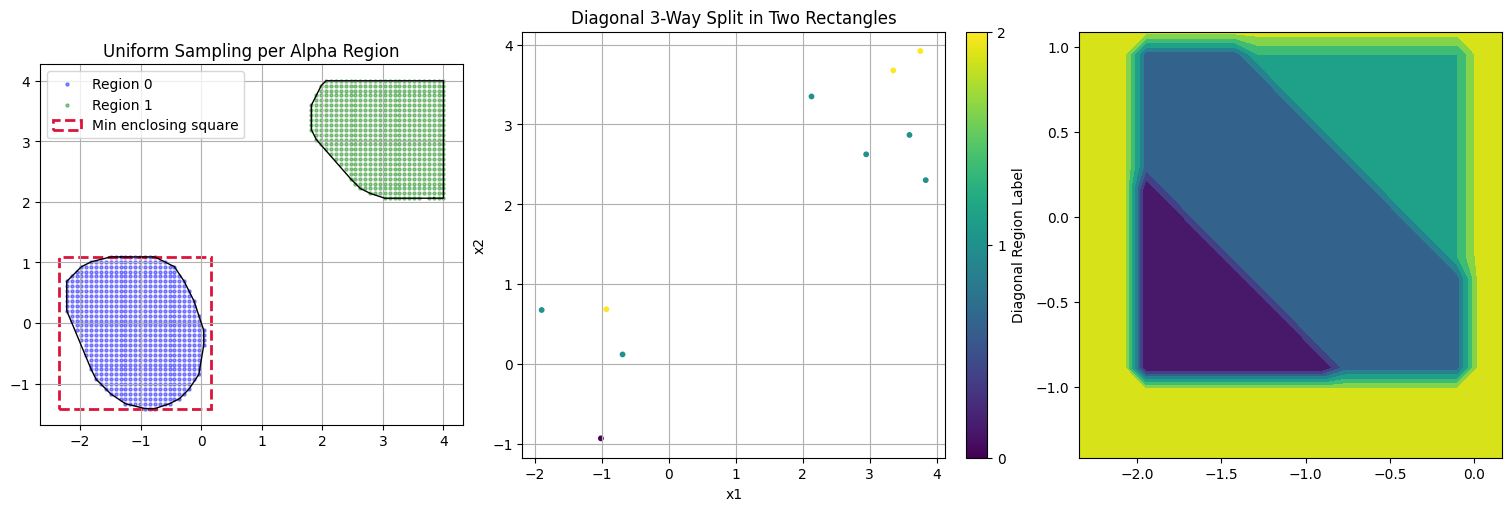

In [61]:
from matplotlib.patches import Rectangle
## Select area -> Classify trained data and entire data into 3 classes

train_x_2c = train_x_2c_o
train_y_2c = train_y_2c_o
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=False, sharey=False,
                        constrained_layout=True)

# Select area and define boundaries
alphas = define_boundaries(axs[0],probs, test_x_2c)

# # define smallest square
square_min_x1, square_max_x1, square_min_x2, square_max_x2 = smallest_square(alphas,i=0)
w = square_max_x1 - square_min_x1
h = square_max_x2 - square_min_x2

rect = Rectangle((square_min_x1, square_min_x2), w, h,
                 fill=False, edgecolor='crimson', linewidth=2, linestyle='--',
                 label='Min enclosing square')
axs[0].add_patch(rect)

axs[0].set_aspect('equal', adjustable='box')  # 진짜 정사각형으로 보이게
axs[0].legend()

# # Classify Trained data into 3 classes
train_x_selected, train_y_selected, sc = ClassifyTrainedData_2Dto3D(fig, axs[1],train_x_2c,train_y_2c)

fig.colorbar(sc, ax=axs[1], ticks=[0, 1, 2]).set_label("Diagonal Region Label")

# # Classify the entire data into 3 classes
train_x_3c_o, train_y_3c_o, test_x1_3c, test_x2_3c, test_x_3c, non_train_x_3c = ClassifyTestData_2Dto3D(axs[2],train_x_selected,square_min_x1, square_max_x1, square_min_x2, square_max_x2, alphas,i=0)


In [62]:
def acquisition(model, test_x, func, var_space = None, num_samples=256):
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_dist = model(test_x)  # MultitaskMultivariateNormal

        # Sampling latent function
        f_samples = test_dist.sample(torch.Size([num_samples]))

        # Normalizing the class probabilities
        prob_samples = torch.softmax(f_samples, dim=1) 

        # Average over samples → [num_classes, num_points]
        probs = prob_samples.mean(dim=0) 
        var = prob_samples.var(dim=0).sum(dim=0)
        
        if func == "most_unprobable":
        # Uncertainty: distance from 0.5
            uncertainty = 1 - probs.max(dim=0).values
        elif func == "entropy":
            uncertainty = -torch.sum(probs * torch.log(probs + 1e-10), dim=0) 
        elif func == "variance":
            if var_space == "prob":
                uncertainty = prob_samples.var(dim=0, correction = 0).sum(dim=0)
            elif var_space == "latent":
                uncertainty = f_samples.var(dim=0, correction = 0).sum(dim=0)
        

        query_idx = torch.argmax(uncertainty)

        total_entropy = -torch.sum(probs * torch.log(probs + 1e-10), dim=0).mean()
        total_entropy = float(total_entropy.sum())

    return probs, var, uncertainty, query_idx, total_entropy

## 3 CLASS CLASSIFICATION

Initial train_x size : 4
Iter 1/50 - Loss: 3.392   lengthscale: 5.050   noise: 0.693
Iter 6/50 - Loss: 3.172   lengthscale: 4.235   noise: 0.972
Iter 11/50 - Loss: 3.007   lengthscale: 3.488   noise: 1.293
Iter 16/50 - Loss: 2.885   lengthscale: 2.879   noise: 1.612
Iter 21/50 - Loss: 2.795   lengthscale: 2.440   noise: 1.885
Iter 26/50 - Loss: 2.724   lengthscale: 2.153   noise: 2.085
Iter 31/50 - Loss: 2.668   lengthscale: 1.974   noise: 2.206
Iter 36/50 - Loss: 2.626   lengthscale: 1.866   noise: 2.257
Iter 41/50 - Loss: 2.597   lengthscale: 1.802   noise: 2.254
Iter 46/50 - Loss: 2.577   lengthscale: 1.765   noise: 2.215
tensor([-1.4205, -0.3594]) tensor(0) number of classes =  3


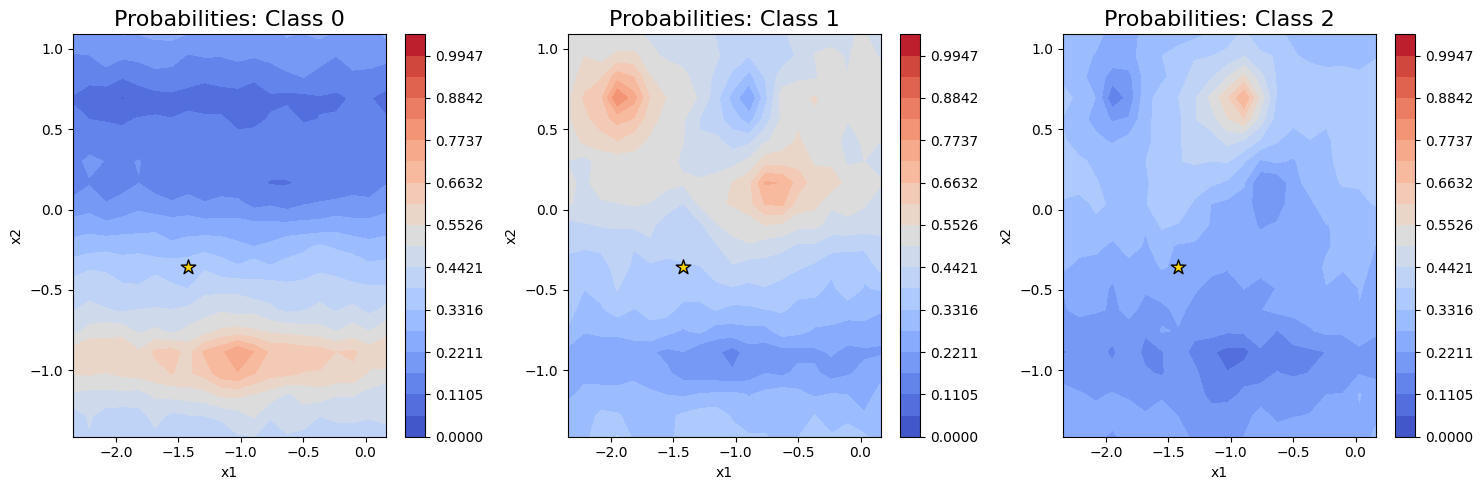

Iter 1/50 - Loss: 3.425   lengthscale: 0.693   noise: 0.693
Iter 6/50 - Loss: 3.063   lengthscale: 0.971   noise: 0.971
Iter 11/50 - Loss: 2.850   lengthscale: 1.275   noise: 1.293
Iter 16/50 - Loss: 2.731   lengthscale: 1.545   noise: 1.650
Iter 21/50 - Loss: 2.665   lengthscale: 1.740   noise: 2.021
Iter 26/50 - Loss: 2.626   lengthscale: 1.852   noise: 2.380
Iter 31/50 - Loss: 2.603   lengthscale: 1.895   noise: 2.701
Iter 36/50 - Loss: 2.588   lengthscale: 1.888   noise: 2.967
Iter 41/50 - Loss: 2.578   lengthscale: 1.847   noise: 3.171
Iter 46/50 - Loss: 2.571   lengthscale: 1.786   noise: 3.313


Detected 2 regions


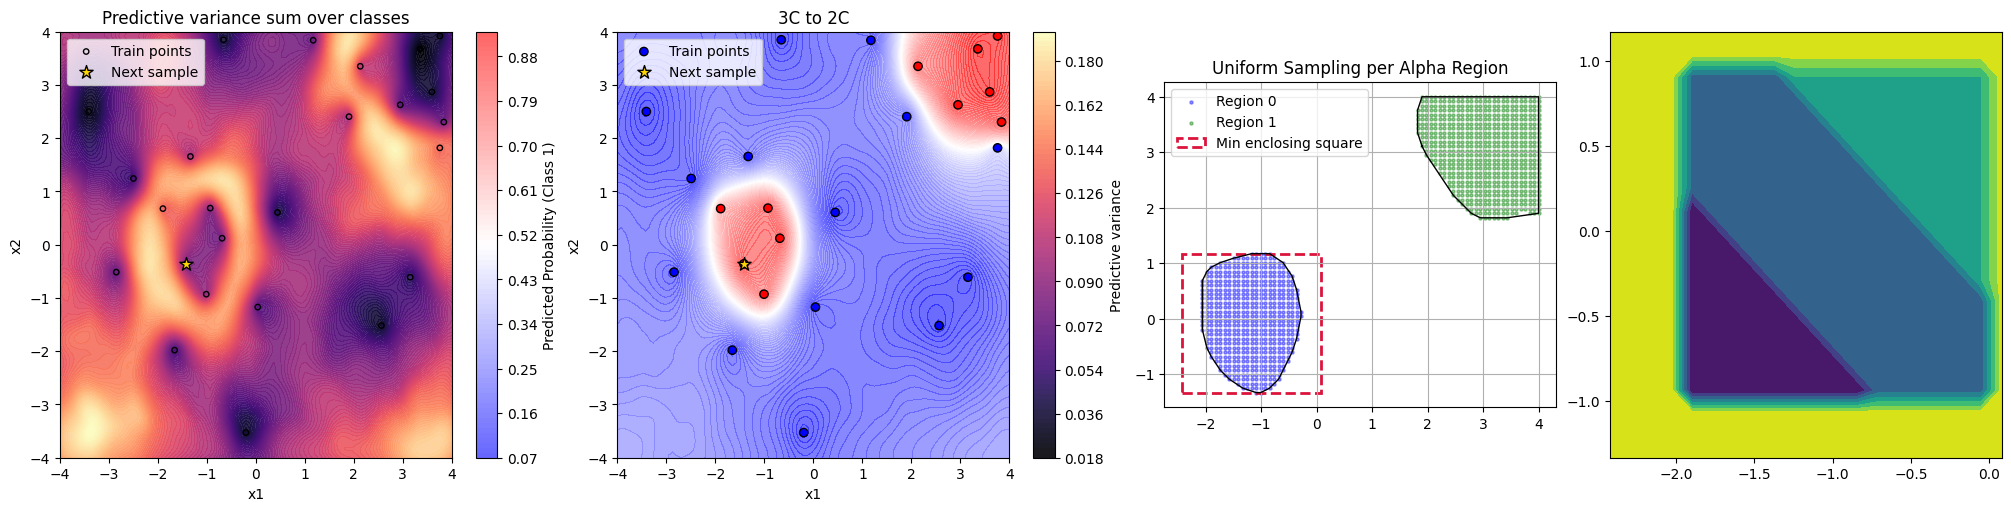

Iter 1/50 - Loss: 3.312   lengthscale: 5.050   noise: 0.693
Iter 6/50 - Loss: 3.104   lengthscale: 4.236   noise: 0.972
Iter 11/50 - Loss: 2.946   lengthscale: 3.500   noise: 1.293
Iter 16/50 - Loss: 2.835   lengthscale: 2.926   noise: 1.612
Iter 21/50 - Loss: 2.757   lengthscale: 2.540   noise: 1.884
Iter 26/50 - Loss: 2.702   lengthscale: 2.288   noise: 2.081
Iter 31/50 - Loss: 2.661   lengthscale: 2.120   noise: 2.198
Iter 36/50 - Loss: 2.630   lengthscale: 2.012   noise: 2.247
Iter 41/50 - Loss: 2.609   lengthscale: 1.938   noise: 2.243
Iter 46/50 - Loss: 2.595   lengthscale: 1.878   noise: 2.203
tensor([0.0808, 1.1717]) tensor(3) number of classes =  3


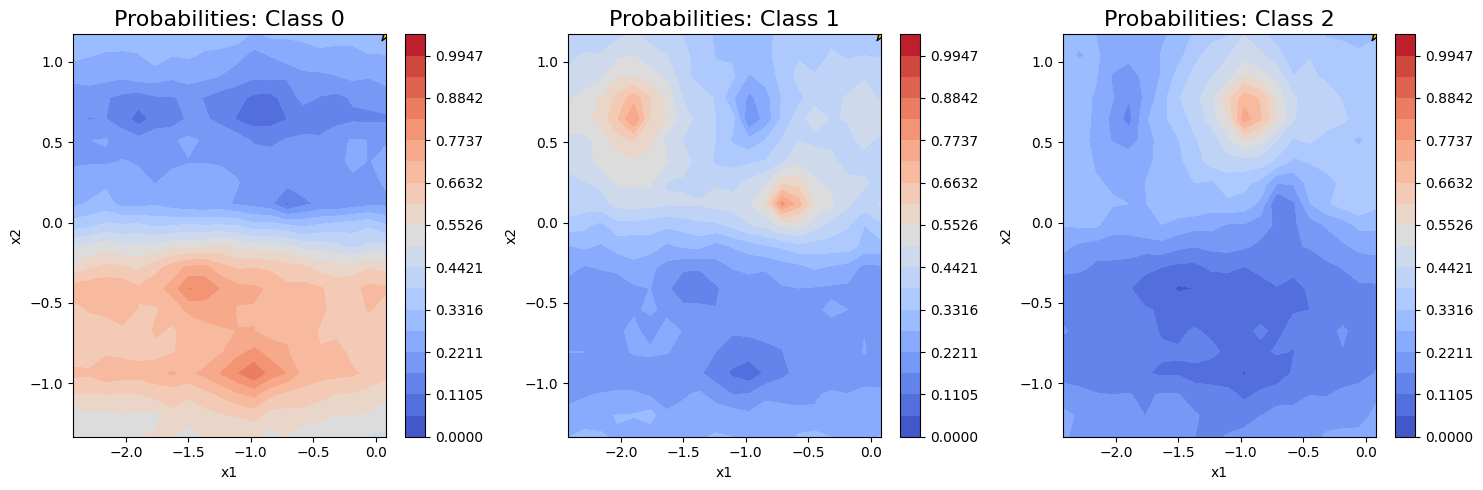

Iter 1/50 - Loss: 3.418   lengthscale: 0.693   noise: 0.693
Iter 6/50 - Loss: 3.056   lengthscale: 0.971   noise: 0.970
Iter 11/50 - Loss: 2.842   lengthscale: 1.273   noise: 1.290
Iter 16/50 - Loss: 2.723   lengthscale: 1.537   noise: 1.644
Iter 21/50 - Loss: 2.656   lengthscale: 1.727   noise: 2.012
Iter 26/50 - Loss: 2.618   lengthscale: 1.837   noise: 2.363
Iter 31/50 - Loss: 2.594   lengthscale: 1.882   noise: 2.670
Iter 36/50 - Loss: 2.580   lengthscale: 1.879   noise: 2.913
Iter 41/50 - Loss: 2.569   lengthscale: 1.844   noise: 3.085
Iter 46/50 - Loss: 2.562   lengthscale: 1.792   noise: 3.188
Detected 2 regions


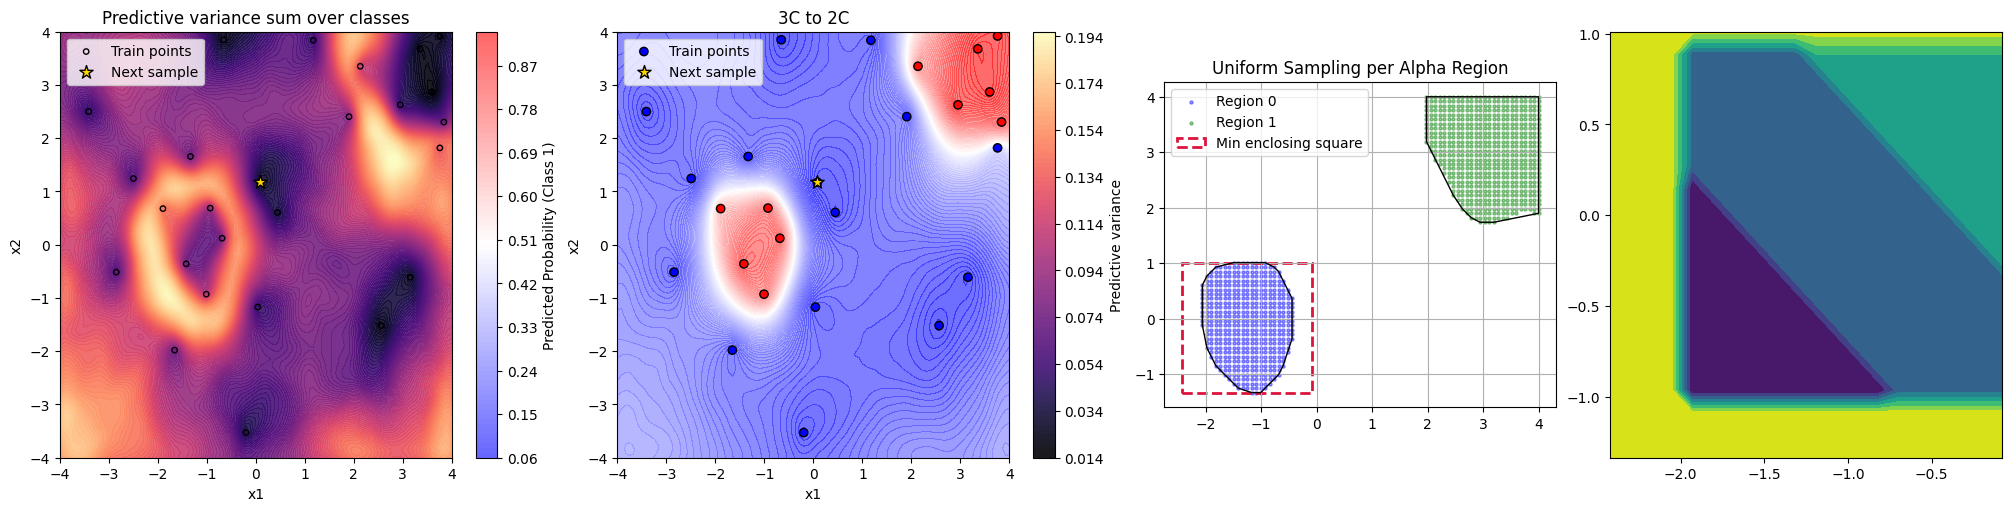

total_entropy - previous_total_entropy = 0.049714713618627566
Iter 1/50 - Loss: 3.255   lengthscale: 5.050   noise: 0.693
Iter 6/50 - Loss: 3.041   lengthscale: 4.200   noise: 0.971
Iter 11/50 - Loss: 2.888   lengthscale: 3.623   noise: 1.280
Iter 16/50 - Loss: 2.783   lengthscale: 3.238   noise: 1.562
Iter 21/50 - Loss: 2.712   lengthscale: 3.023   noise: 1.760
Iter 26/50 - Loss: 2.662   lengthscale: 2.914   noise: 1.859
Iter 31/50 - Loss: 2.621   lengthscale: 2.851   noise: 1.881
Iter 36/50 - Loss: 2.588   lengthscale: 2.796   noise: 1.851
Iter 41/50 - Loss: 2.562   lengthscale: 2.738   noise: 1.793
Iter 46/50 - Loss: 2.543   lengthscale: 2.685   noise: 1.723
tensor([-2.4242,  0.0234]) tensor(3) number of classes =  4


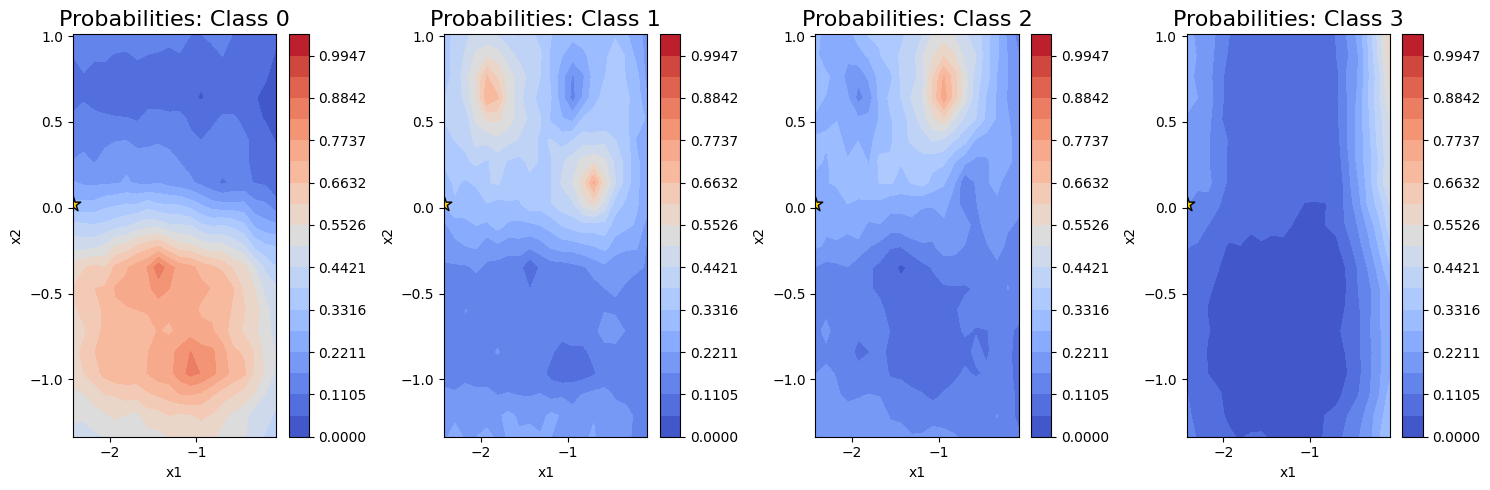

Iter 1/50 - Loss: 3.412   lengthscale: 0.693   noise: 0.693
Iter 6/50 - Loss: 3.052   lengthscale: 0.970   noise: 0.969
Iter 11/50 - Loss: 2.839   lengthscale: 1.268   noise: 1.289
Iter 16/50 - Loss: 2.720   lengthscale: 1.523   noise: 1.645
Iter 21/50 - Loss: 2.652   lengthscale: 1.703   noise: 2.013
Iter 26/50 - Loss: 2.613   lengthscale: 1.808   noise: 2.360
Iter 31/50 - Loss: 2.588   lengthscale: 1.852   noise: 2.652
Iter 36/50 - Loss: 2.573   lengthscale: 1.853   noise: 2.867
Iter 41/50 - Loss: 2.562   lengthscale: 1.827   noise: 3.003
Iter 46/50 - Loss: 2.554   lengthscale: 1.786   noise: 3.067
Detected 2 regions


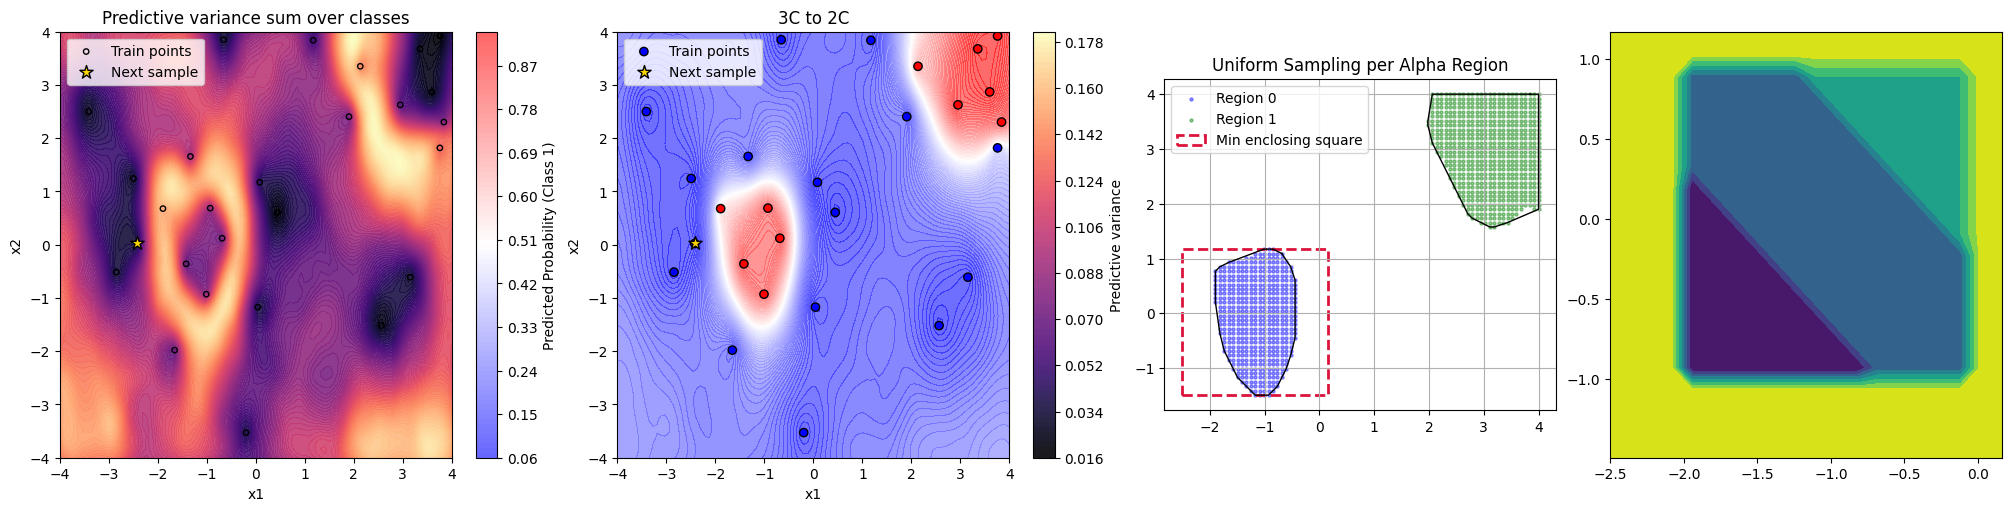

total_entropy - previous_total_entropy = 0.009821109748479181
Iter 1/50 - Loss: 3.278   lengthscale: 5.050   noise: 0.693
Iter 6/50 - Loss: 3.062   lengthscale: 4.679   noise: 0.972
Iter 11/50 - Loss: 2.903   lengthscale: 4.222   noise: 1.292
Iter 16/50 - Loss: 2.793   lengthscale: 3.809   noise: 1.610
Iter 21/50 - Loss: 2.720   lengthscale: 3.528   noise: 1.880
Iter 26/50 - Loss: 2.671   lengthscale: 3.346   noise: 2.076
Iter 31/50 - Loss: 2.636   lengthscale: 3.228   noise: 2.197
Iter 36/50 - Loss: 2.608   lengthscale: 3.125   noise: 2.253
Iter 41/50 - Loss: 2.586   lengthscale: 3.009   noise: 2.261
Iter 46/50 - Loss: 2.569   lengthscale: 2.889   noise: 2.231
tensor([-2.0840, -0.0914]) tensor(3) number of classes =  4


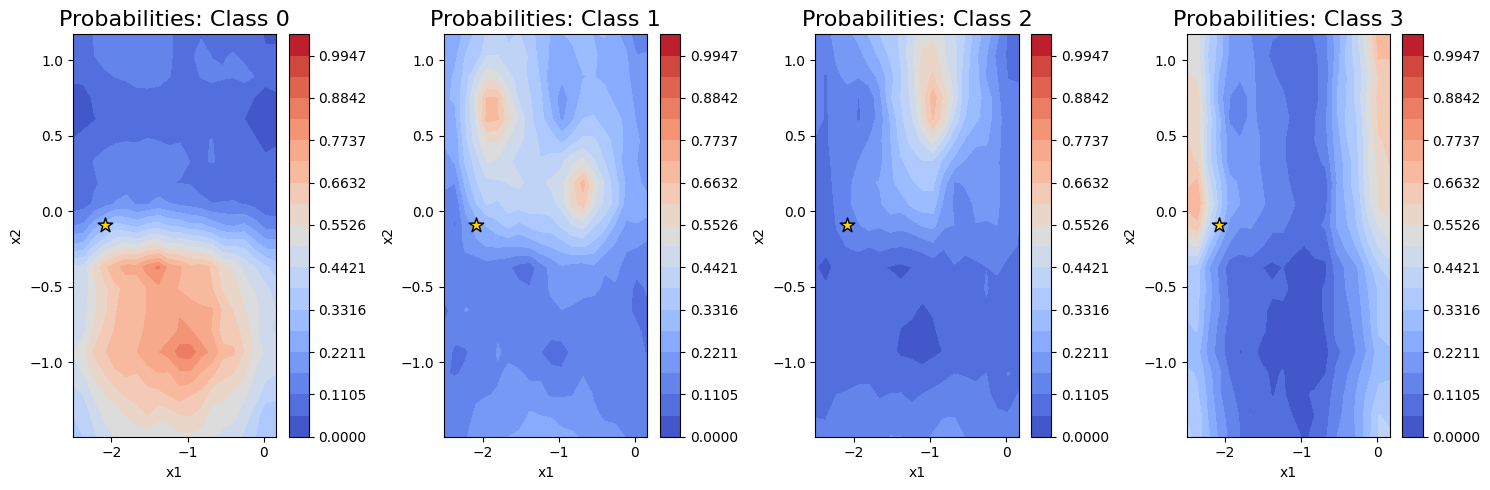

Iter 1/50 - Loss: 3.402   lengthscale: 0.693   noise: 0.693
Iter 6/50 - Loss: 3.045   lengthscale: 0.970   noise: 0.968
Iter 11/50 - Loss: 2.835   lengthscale: 1.264   noise: 1.287
Iter 16/50 - Loss: 2.716   lengthscale: 1.513   noise: 1.644
Iter 21/50 - Loss: 2.648   lengthscale: 1.689   noise: 2.015
Iter 26/50 - Loss: 2.608   lengthscale: 1.793   noise: 2.359
Iter 31/50 - Loss: 2.583   lengthscale: 1.840   noise: 2.634
Iter 36/50 - Loss: 2.568   lengthscale: 1.847   noise: 2.820
Iter 41/50 - Loss: 2.556   lengthscale: 1.830   noise: 2.919
Iter 46/50 - Loss: 2.548   lengthscale: 1.798   noise: 2.949
Detected 2 regions


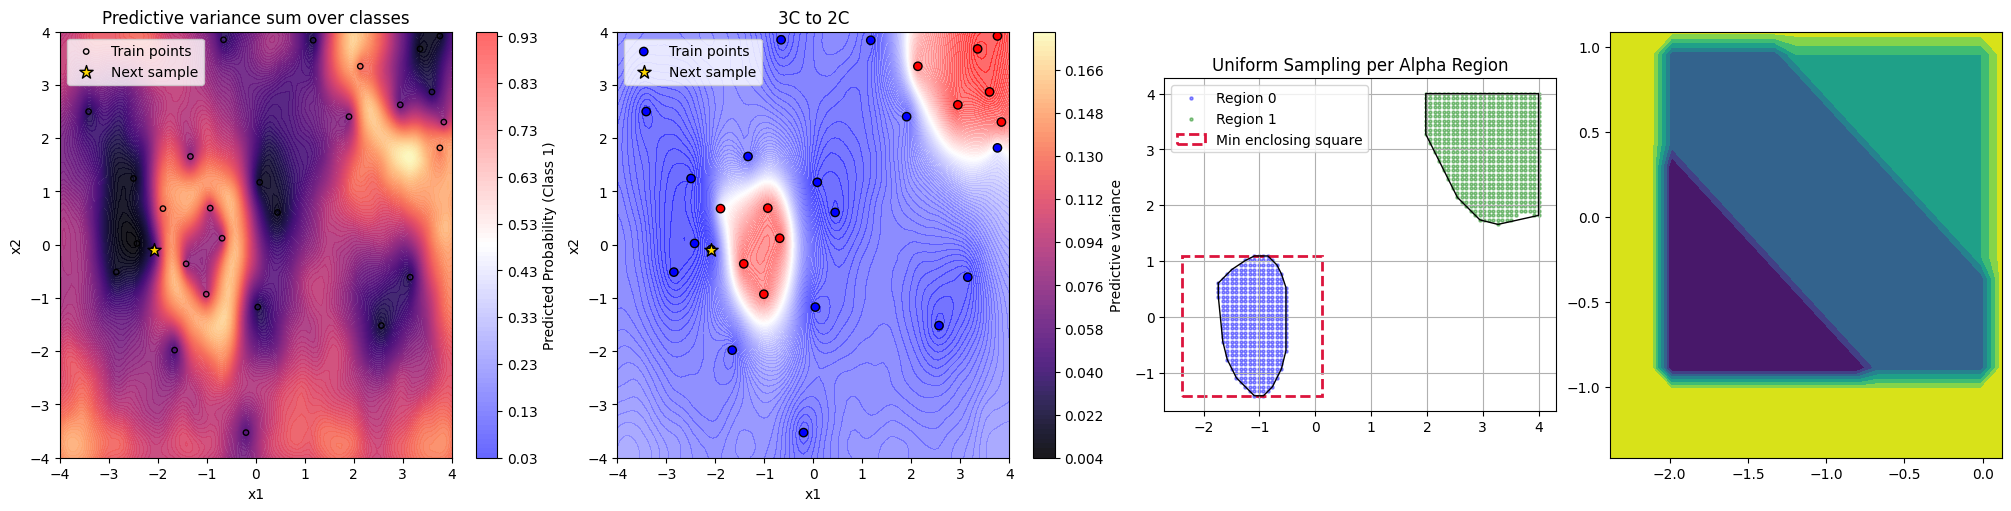

total_entropy - previous_total_entropy = 0.05431161467699803
Iter 1/50 - Loss: 3.204   lengthscale: 5.050   noise: 0.693
Iter 6/50 - Loss: 3.001   lengthscale: 4.721   noise: 0.972
Iter 11/50 - Loss: 2.853   lengthscale: 4.371   noise: 1.293
Iter 16/50 - Loss: 2.753   lengthscale: 4.003   noise: 1.617
Iter 21/50 - Loss: 2.687   lengthscale: 3.730   noise: 1.898
Iter 26/50 - Loss: 2.643   lengthscale: 3.537   noise: 2.110
Iter 31/50 - Loss: 2.613   lengthscale: 3.407   noise: 2.247
Iter 36/50 - Loss: 2.591   lengthscale: 3.331   noise: 2.319
Iter 41/50 - Loss: 2.573   lengthscale: 3.250   noise: 2.340
Iter 46/50 - Loss: 2.560   lengthscale: 3.156   noise: 2.322
tensor([-0.4062, -0.2275]) tensor(1) number of classes =  4


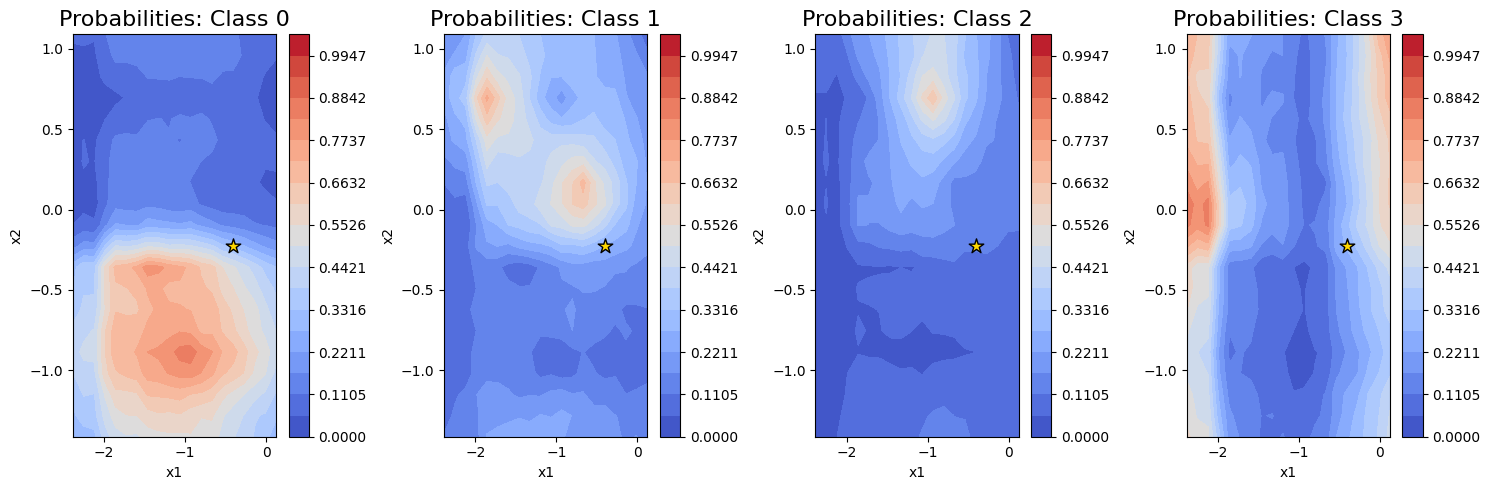

Iter 1/50 - Loss: 3.389   lengthscale: 0.693   noise: 0.693
Iter 6/50 - Loss: 3.035   lengthscale: 0.970   noise: 0.970
Iter 11/50 - Loss: 2.829   lengthscale: 1.263   noise: 1.293
Iter 16/50 - Loss: 2.714   lengthscale: 1.510   noise: 1.653
Iter 21/50 - Loss: 2.649   lengthscale: 1.679   noise: 2.026
Iter 26/50 - Loss: 2.610   lengthscale: 1.772   noise: 2.376
Iter 31/50 - Loss: 2.586   lengthscale: 1.804   noise: 2.669
Iter 36/50 - Loss: 2.571   lengthscale: 1.796   noise: 2.884
Iter 41/50 - Loss: 2.560   lengthscale: 1.762   noise: 3.017
Iter 46/50 - Loss: 2.552   lengthscale: 1.714   noise: 3.077
Detected 2 regions


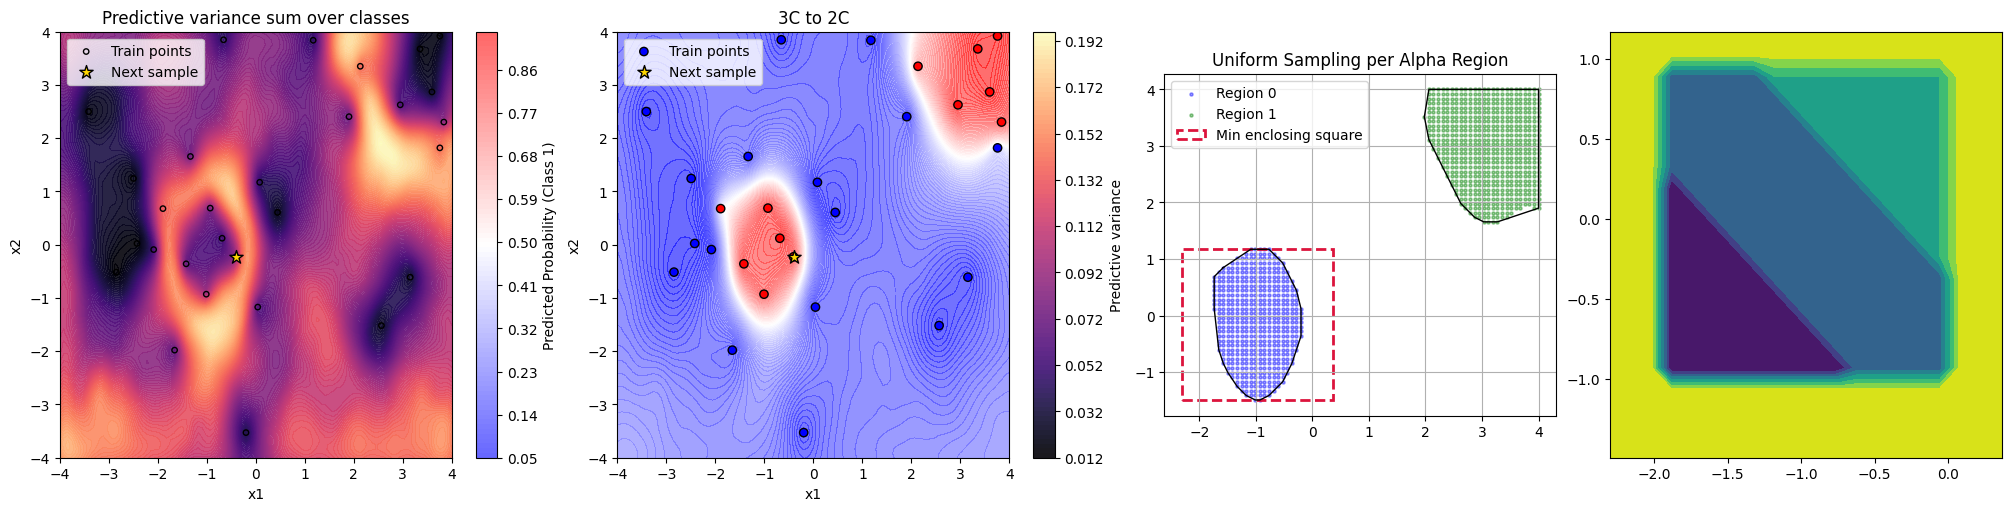

total_entropy - previous_total_entropy = 0.04640853077395648
Iter 1/50 - Loss: 3.144   lengthscale: 5.050   noise: 0.693
Iter 6/50 - Loss: 2.951   lengthscale: 4.435   noise: 0.972
Iter 11/50 - Loss: 2.813   lengthscale: 3.873   noise: 1.293
Iter 16/50 - Loss: 2.720   lengthscale: 3.472   noise: 1.613
Iter 21/50 - Loss: 2.660   lengthscale: 3.276   noise: 1.891
Iter 26/50 - Loss: 2.622   lengthscale: 3.216   noise: 2.100
Iter 31/50 - Loss: 2.596   lengthscale: 3.214   noise: 2.240
Iter 36/50 - Loss: 2.577   lengthscale: 3.237   noise: 2.319
Iter 41/50 - Loss: 2.564   lengthscale: 3.270   noise: 2.351
Iter 46/50 - Loss: 2.556   lengthscale: 3.306   noise: 2.351
tensor([-0.3381,  0.8910]) tensor(2) number of classes =  4


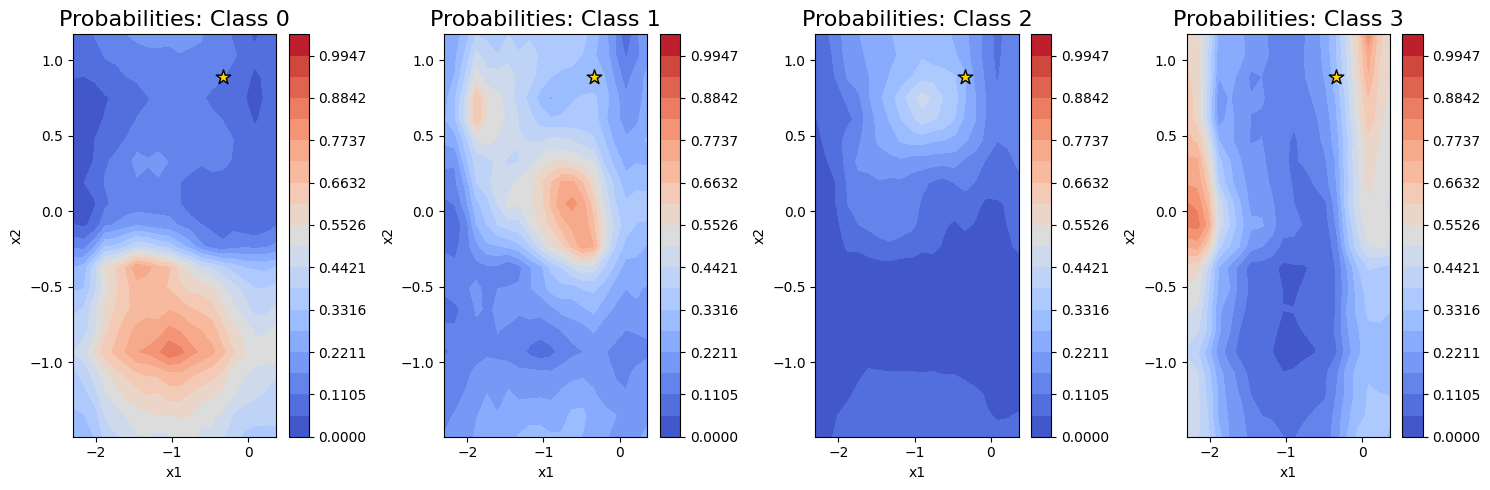

Iter 1/50 - Loss: 3.381   lengthscale: 0.693   noise: 0.693
Iter 6/50 - Loss: 3.032   lengthscale: 0.969   noise: 0.971
Iter 11/50 - Loss: 2.832   lengthscale: 1.260   noise: 1.299
Iter 16/50 - Loss: 2.720   lengthscale: 1.501   noise: 1.665
Iter 21/50 - Loss: 2.655   lengthscale: 1.660   noise: 2.044
Iter 26/50 - Loss: 2.616   lengthscale: 1.743   noise: 2.404
Iter 31/50 - Loss: 2.592   lengthscale: 1.766   noise: 2.715
Iter 36/50 - Loss: 2.576   lengthscale: 1.749   noise: 2.959
Iter 41/50 - Loss: 2.566   lengthscale: 1.710   noise: 3.130
Iter 46/50 - Loss: 2.558   lengthscale: 1.659   noise: 3.234
Detected 2 regions


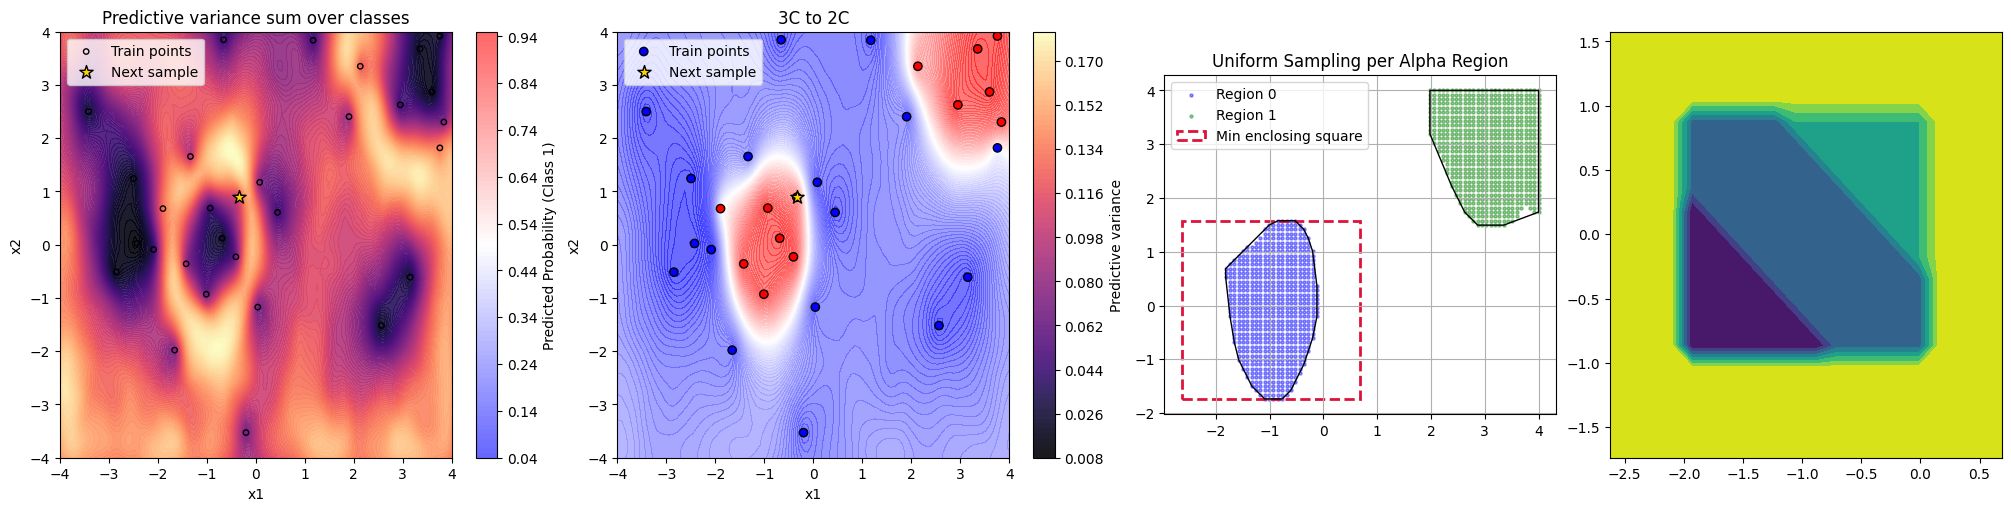

total_entropy - previous_total_entropy = 0.058013468820263384
Iter 1/50 - Loss: 3.131   lengthscale: 5.050   noise: 0.693
Iter 6/50 - Loss: 2.936   lengthscale: 4.442   noise: 0.972
Iter 11/50 - Loss: 2.796   lengthscale: 4.018   noise: 1.291
Iter 16/50 - Loss: 2.701   lengthscale: 3.804   noise: 1.611
Iter 21/50 - Loss: 2.643   lengthscale: 3.691   noise: 1.885
Iter 26/50 - Loss: 2.607   lengthscale: 3.616   noise: 2.086
Iter 31/50 - Loss: 2.583   lengthscale: 3.558   noise: 2.206
Iter 36/50 - Loss: 2.565   lengthscale: 3.475   noise: 2.256
Iter 41/50 - Loss: 2.552   lengthscale: 3.355   noise: 2.251
Iter 46/50 - Loss: 2.542   lengthscale: 3.211   noise: 2.207
tensor([-0.1850,  1.5758]) tensor(3) number of classes =  4


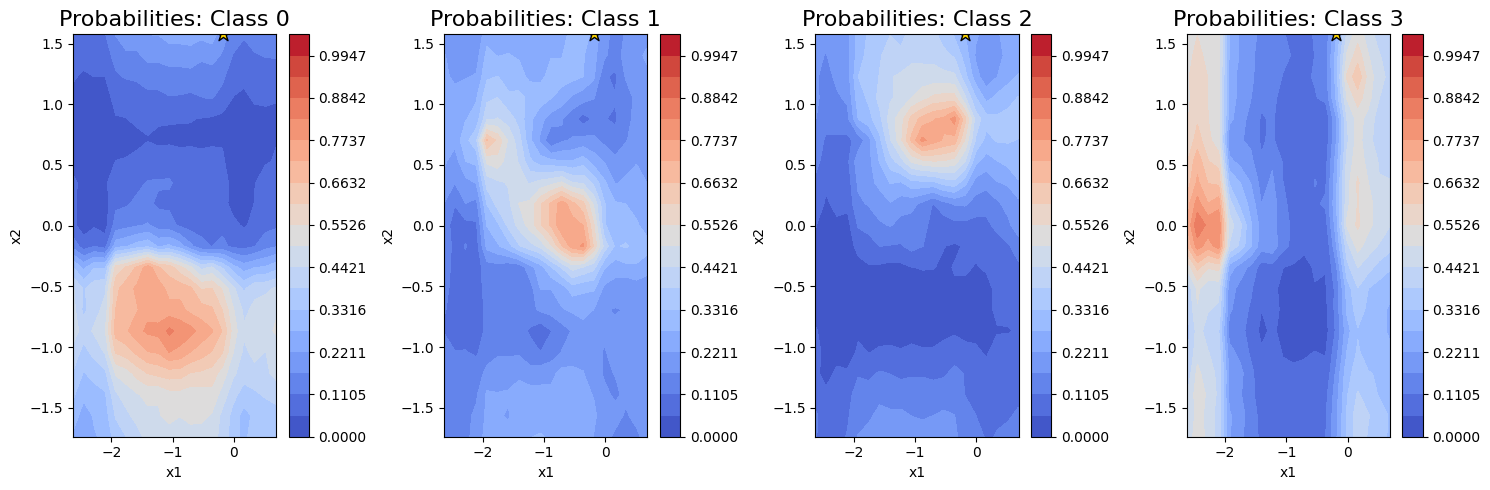

Iter 1/50 - Loss: 3.374   lengthscale: 0.693   noise: 0.693
Iter 6/50 - Loss: 3.025   lengthscale: 0.969   noise: 0.971
Iter 11/50 - Loss: 2.824   lengthscale: 1.260   noise: 1.297
Iter 16/50 - Loss: 2.713   lengthscale: 1.502   noise: 1.661
Iter 21/50 - Loss: 2.649   lengthscale: 1.665   noise: 2.039
Iter 26/50 - Loss: 2.612   lengthscale: 1.752   noise: 2.394
Iter 31/50 - Loss: 2.588   lengthscale: 1.781   noise: 2.695
Iter 36/50 - Loss: 2.573   lengthscale: 1.770   noise: 2.920
Iter 41/50 - Loss: 2.562   lengthscale: 1.734   noise: 3.066
Iter 46/50 - Loss: 2.554   lengthscale: 1.686   noise: 3.140
Detected 2 regions


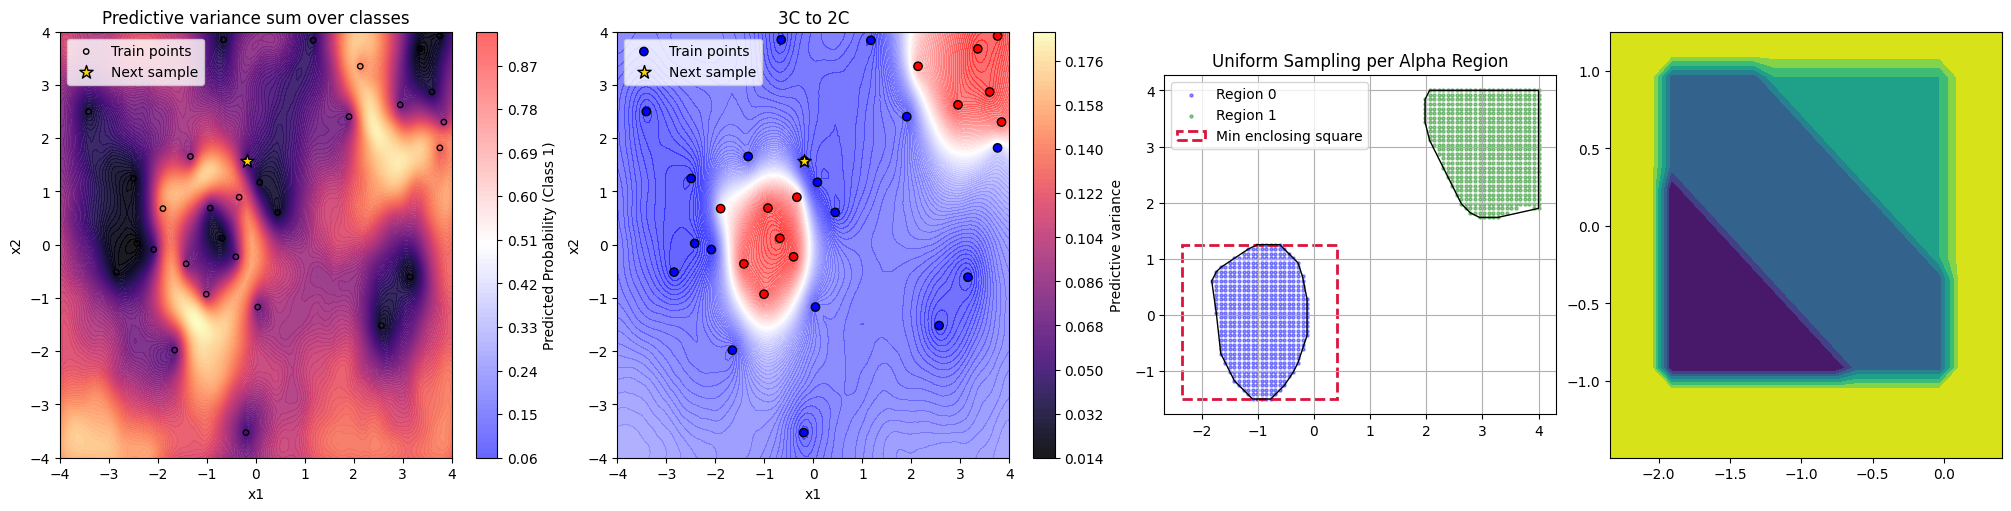

total_entropy - previous_total_entropy = 0.04492777041039257
Iter 1/50 - Loss: 3.086   lengthscale: 5.050   noise: 0.693
Iter 6/50 - Loss: 2.898   lengthscale: 4.438   noise: 0.972
Iter 11/50 - Loss: 2.765   lengthscale: 3.877   noise: 1.288
Iter 16/50 - Loss: 2.681   lengthscale: 3.437   noise: 1.594
Iter 21/50 - Loss: 2.631   lengthscale: 3.148   noise: 1.840
Iter 26/50 - Loss: 2.600   lengthscale: 2.966   noise: 2.002
Iter 31/50 - Loss: 2.578   lengthscale: 2.843   noise: 2.081
Iter 36/50 - Loss: 2.561   lengthscale: 2.744   noise: 2.096
Iter 41/50 - Loss: 2.547   lengthscale: 2.634   noise: 2.063
Iter 46/50 - Loss: 2.538   lengthscale: 2.489   noise: 2.001
tensor([-1.0420,  1.2525]) tensor(3) number of classes =  4


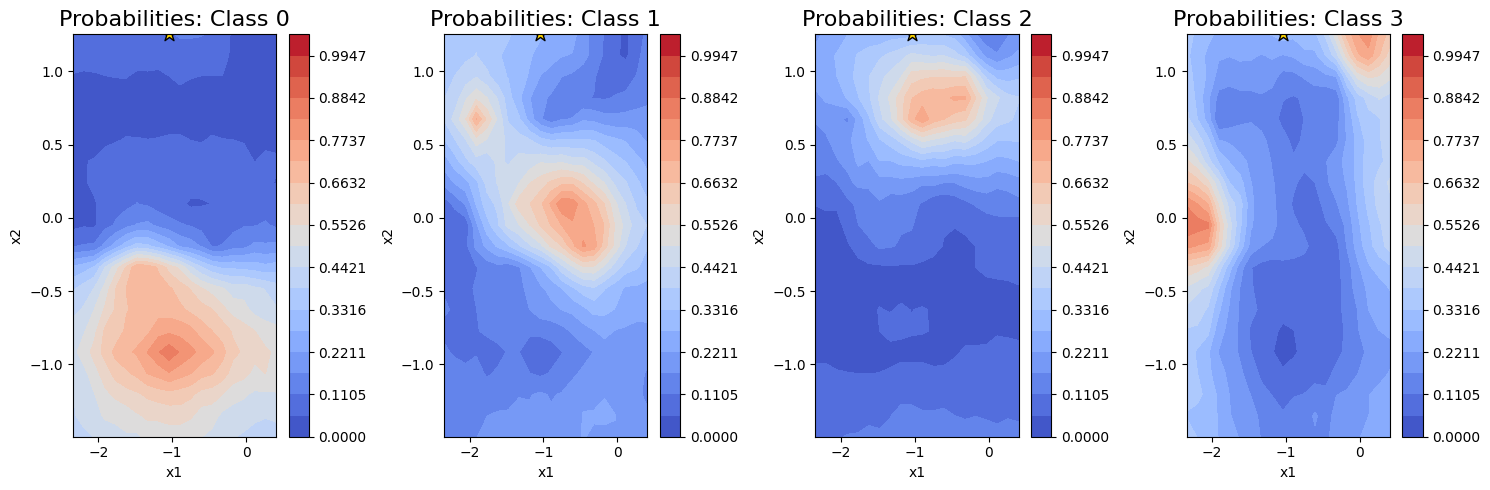

Iter 1/50 - Loss: 3.366   lengthscale: 0.693   noise: 0.693
Iter 6/50 - Loss: 3.019   lengthscale: 0.969   noise: 0.971
Iter 11/50 - Loss: 2.821   lengthscale: 1.260   noise: 1.297
Iter 16/50 - Loss: 2.711   lengthscale: 1.504   noise: 1.665
Iter 21/50 - Loss: 2.648   lengthscale: 1.673   noise: 2.047
Iter 26/50 - Loss: 2.611   lengthscale: 1.768   noise: 2.407
Iter 31/50 - Loss: 2.589   lengthscale: 1.805   noise: 2.710
Iter 36/50 - Loss: 2.574   lengthscale: 1.801   noise: 2.935
Iter 41/50 - Loss: 2.564   lengthscale: 1.771   noise: 3.075
Iter 46/50 - Loss: 2.556   lengthscale: 1.726   noise: 3.140
Detected 2 regions


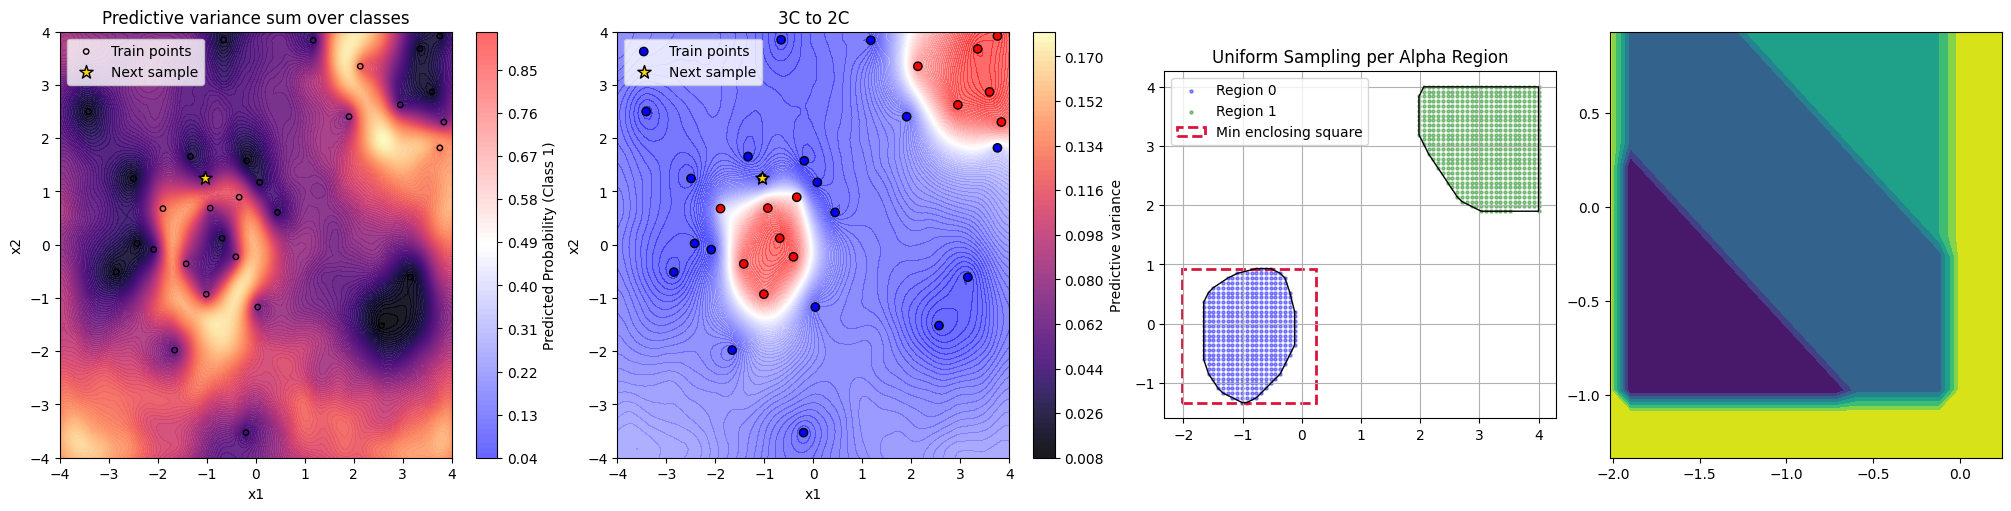

total_entropy - previous_total_entropy = 0.0582504972915505
Iter 1/50 - Loss: 3.047   lengthscale: 5.050   noise: 0.693
Iter 6/50 - Loss: 2.869   lengthscale: 4.438   noise: 0.972
Iter 11/50 - Loss: 2.743   lengthscale: 3.887   noise: 1.288
Iter 16/50 - Loss: 2.663   lengthscale: 3.472   noise: 1.594
Iter 21/50 - Loss: 2.616   lengthscale: 3.188   noise: 1.840
Iter 26/50 - Loss: 2.588   lengthscale: 2.998   noise: 1.997
Iter 31/50 - Loss: 2.567   lengthscale: 2.900   noise: 2.069
Iter 36/50 - Loss: 2.549   lengthscale: 2.851   noise: 2.070
Iter 41/50 - Loss: 2.535   lengthscale: 2.823   noise: 2.022
Iter 46/50 - Loss: 2.524   lengthscale: 2.810   noise: 1.943
tensor([0.1233, 0.4530]) tensor(3) number of classes =  4


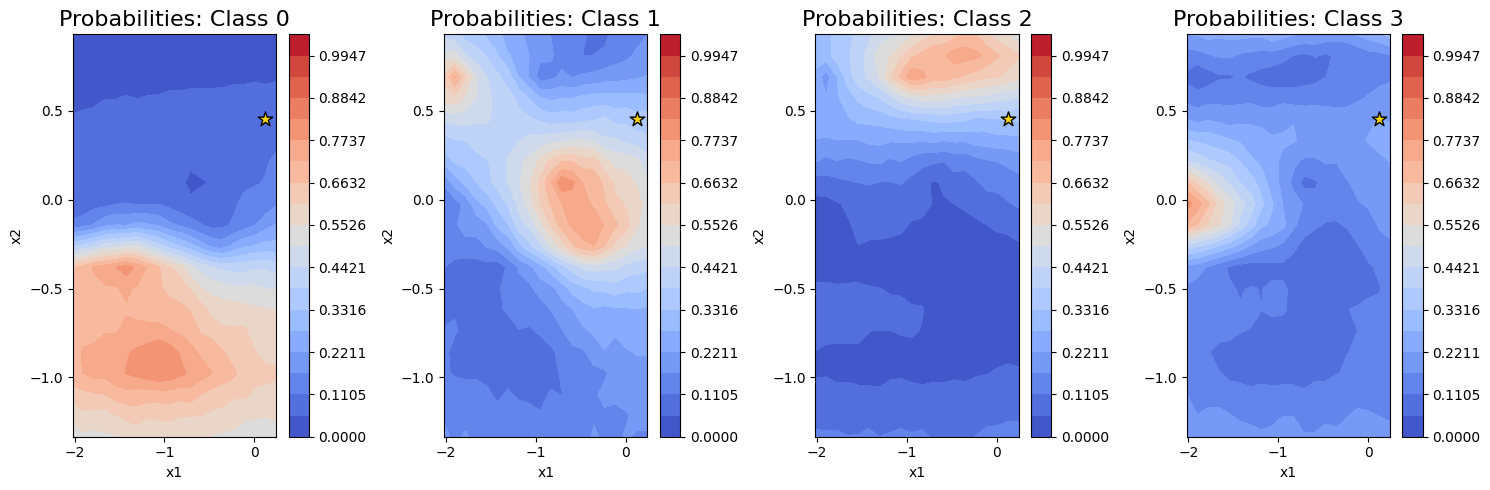

Iter 1/50 - Loss: 3.357   lengthscale: 0.693   noise: 0.693
Iter 6/50 - Loss: 3.013   lengthscale: 0.969   noise: 0.970
Iter 11/50 - Loss: 2.816   lengthscale: 1.256   noise: 1.297
Iter 16/50 - Loss: 2.706   lengthscale: 1.493   noise: 1.665
Iter 21/50 - Loss: 2.643   lengthscale: 1.656   noise: 2.046
Iter 26/50 - Loss: 2.606   lengthscale: 1.747   noise: 2.397
Iter 31/50 - Loss: 2.583   lengthscale: 1.785   noise: 2.676
Iter 36/50 - Loss: 2.568   lengthscale: 1.784   noise: 2.862
Iter 41/50 - Loss: 2.557   lengthscale: 1.760   noise: 2.958
Iter 46/50 - Loss: 2.549   lengthscale: 1.723   noise: 2.981


Detected 2 regions


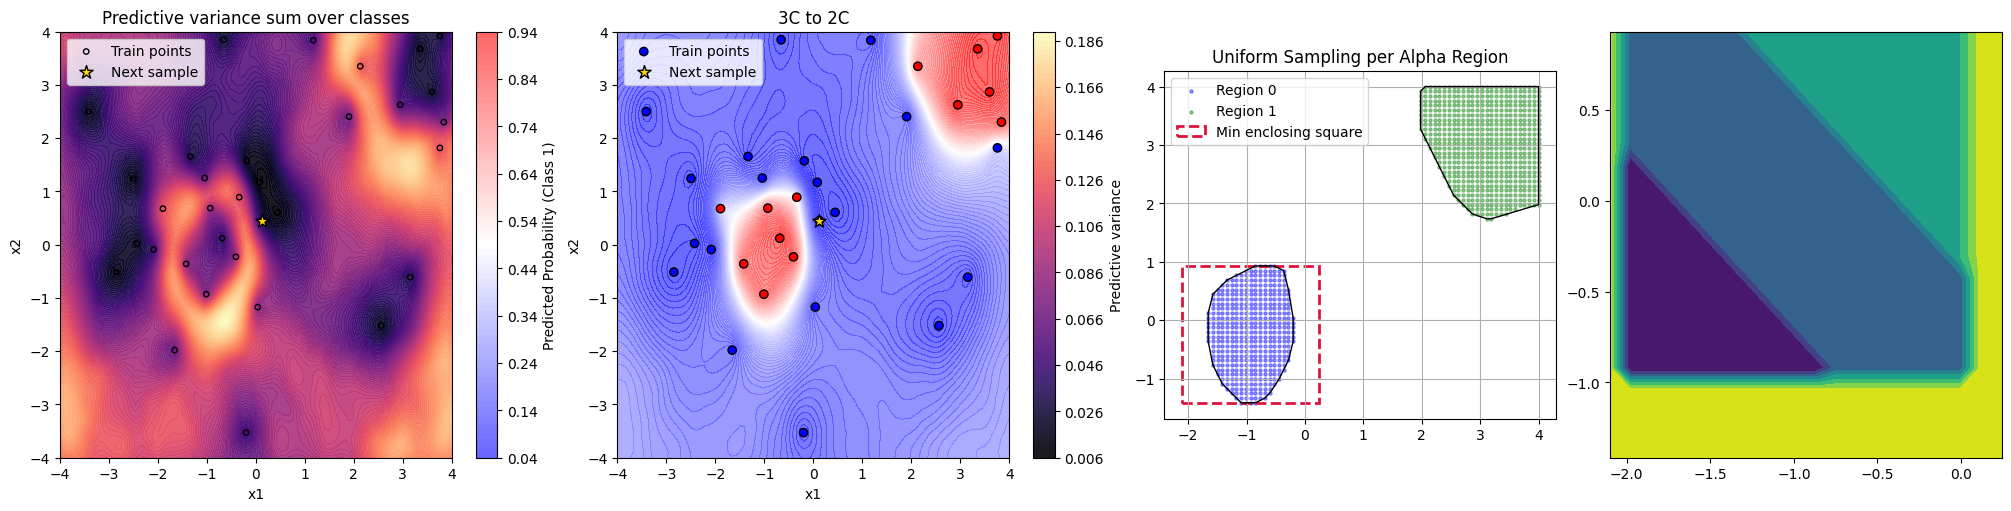

total_entropy - previous_total_entropy = 0.0004420133085005079
Iter 1/50 - Loss: 3.018   lengthscale: 5.050   noise: 0.693
Iter 6/50 - Loss: 2.848   lengthscale: 4.439   noise: 0.972
Iter 11/50 - Loss: 2.729   lengthscale: 3.888   noise: 1.288
Iter 16/50 - Loss: 2.652   lengthscale: 3.470   noise: 1.595
Iter 21/50 - Loss: 2.608   lengthscale: 3.210   noise: 1.840
Iter 26/50 - Loss: 2.580   lengthscale: 3.060   noise: 1.998
Iter 31/50 - Loss: 2.561   lengthscale: 2.969   noise: 2.074
Iter 36/50 - Loss: 2.545   lengthscale: 2.918   noise: 2.085
Iter 41/50 - Loss: 2.533   lengthscale: 2.887   noise: 2.054
Iter 46/50 - Loss: 2.524   lengthscale: 2.859   noise: 1.997
tensor([-1.4843, -0.1808]) tensor(1) number of classes =  4


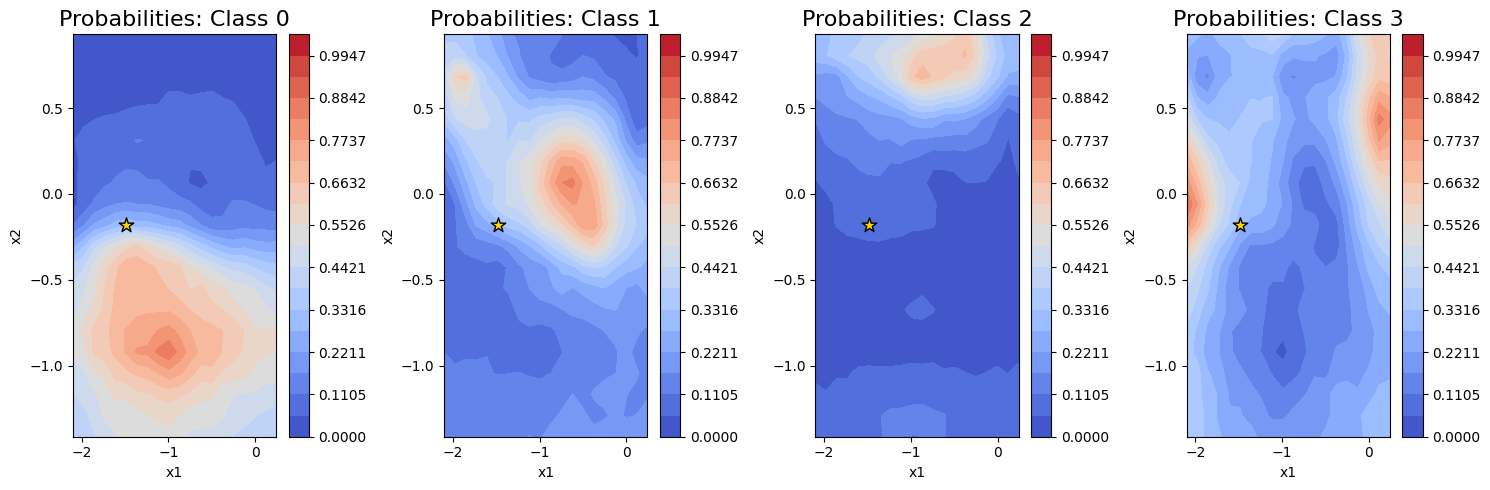

Iter 1/50 - Loss: 3.342   lengthscale: 0.693   noise: 0.693
Iter 6/50 - Loss: 3.002   lengthscale: 0.968   noise: 0.971
Iter 11/50 - Loss: 2.808   lengthscale: 1.252   noise: 1.299
Iter 16/50 - Loss: 2.700   lengthscale: 1.482   noise: 1.666
Iter 21/50 - Loss: 2.638   lengthscale: 1.634   noise: 2.043
Iter 26/50 - Loss: 2.601   lengthscale: 1.713   noise: 2.388
Iter 31/50 - Loss: 2.579   lengthscale: 1.737   noise: 2.664
Iter 36/50 - Loss: 2.564   lengthscale: 1.725   noise: 2.852
Iter 41/50 - Loss: 2.553   lengthscale: 1.691   noise: 2.953
Iter 46/50 - Loss: 2.544   lengthscale: 1.644   noise: 2.979


Detected 2 regions


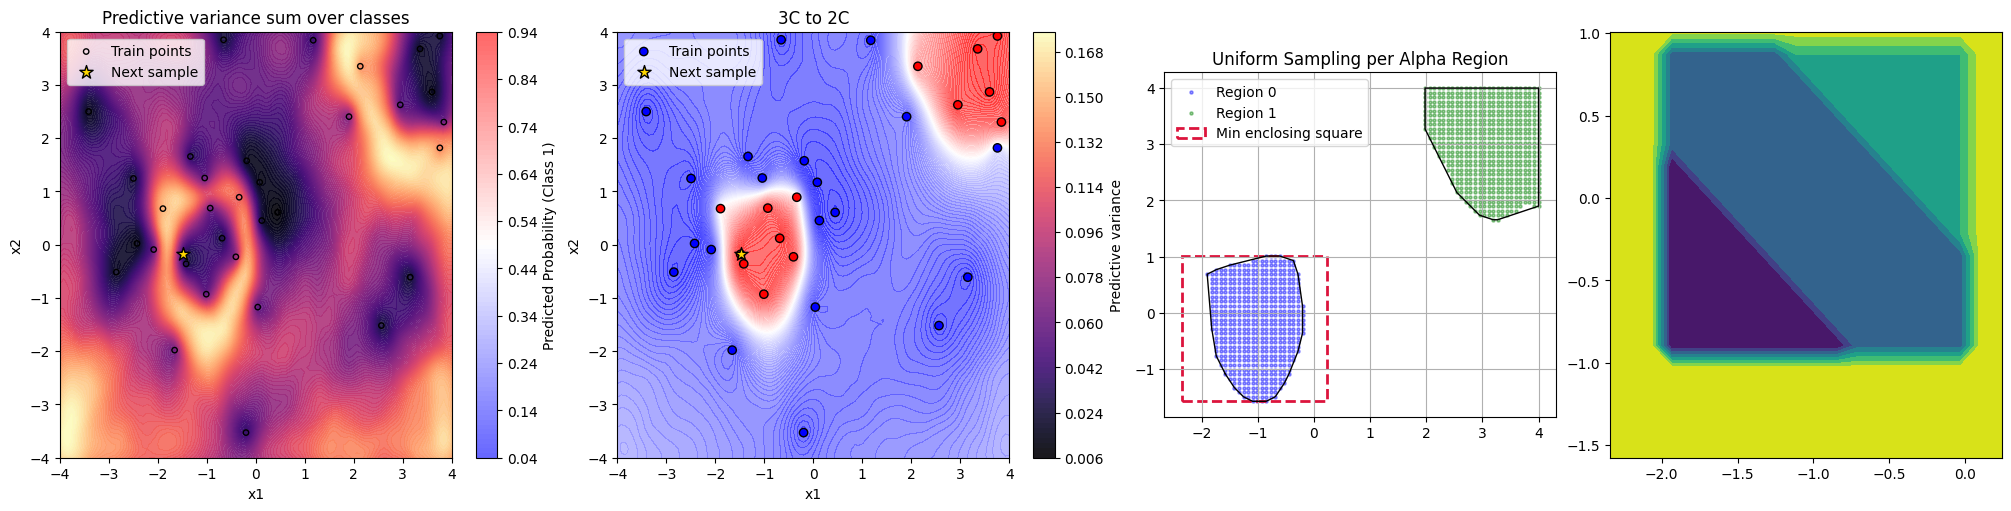

total_entropy - previous_total_entropy = 0.014277767993541872
Iter 1/50 - Loss: 3.009   lengthscale: 5.050   noise: 0.693
Iter 6/50 - Loss: 2.841   lengthscale: 4.538   noise: 0.972
Iter 11/50 - Loss: 2.722   lengthscale: 3.980   noise: 1.291
Iter 16/50 - Loss: 2.646   lengthscale: 3.543   noise: 1.605
Iter 21/50 - Loss: 2.601   lengthscale: 3.261   noise: 1.865
Iter 26/50 - Loss: 2.574   lengthscale: 3.080   noise: 2.044
Iter 31/50 - Loss: 2.555   lengthscale: 2.977   noise: 2.140
Iter 36/50 - Loss: 2.541   lengthscale: 2.916   noise: 2.169
Iter 41/50 - Loss: 2.529   lengthscale: 2.877   noise: 2.149
Iter 46/50 - Loss: 2.521   lengthscale: 2.856   noise: 2.097
tensor([-1.9351,  1.0101]) tensor(3) number of classes =  4


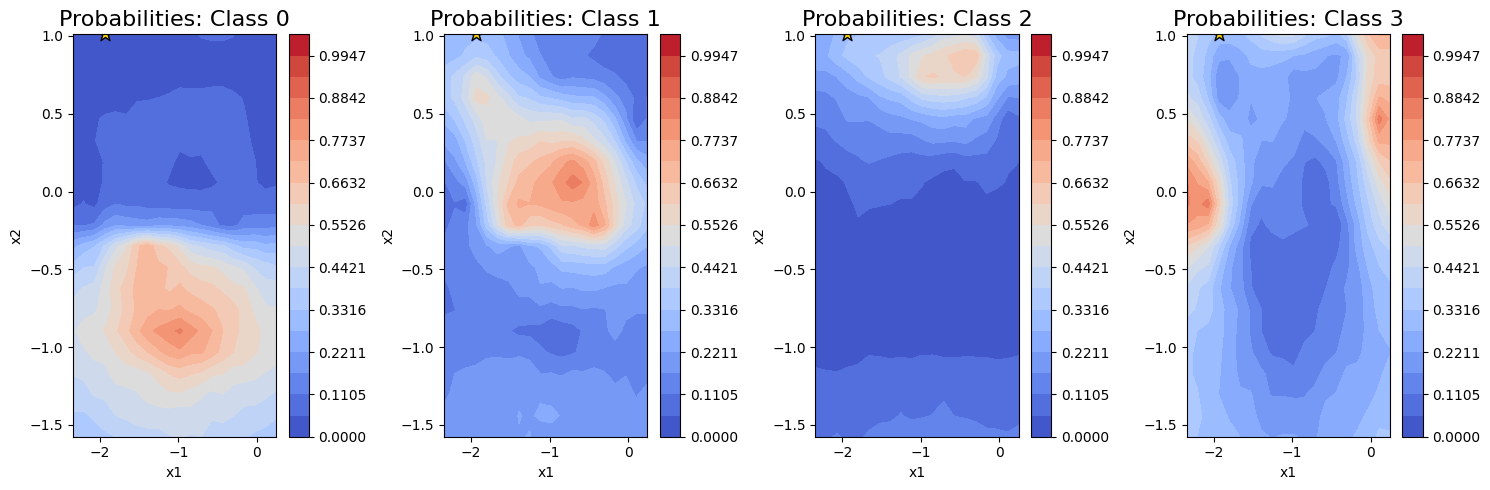

Iter 1/50 - Loss: 3.334   lengthscale: 0.693   noise: 0.693
Iter 6/50 - Loss: 2.995   lengthscale: 0.968   noise: 0.970
Iter 11/50 - Loss: 2.802   lengthscale: 1.252   noise: 1.298
Iter 16/50 - Loss: 2.694   lengthscale: 1.483   noise: 1.665
Iter 21/50 - Loss: 2.633   lengthscale: 1.639   noise: 2.041
Iter 26/50 - Loss: 2.597   lengthscale: 1.725   noise: 2.378
Iter 31/50 - Loss: 2.574   lengthscale: 1.757   noise: 2.635
Iter 36/50 - Loss: 2.559   lengthscale: 1.754   noise: 2.793
Iter 41/50 - Loss: 2.549   lengthscale: 1.728   noise: 2.860
Iter 46/50 - Loss: 2.540   lengthscale: 1.689   noise: 2.857
Detected 2 regions


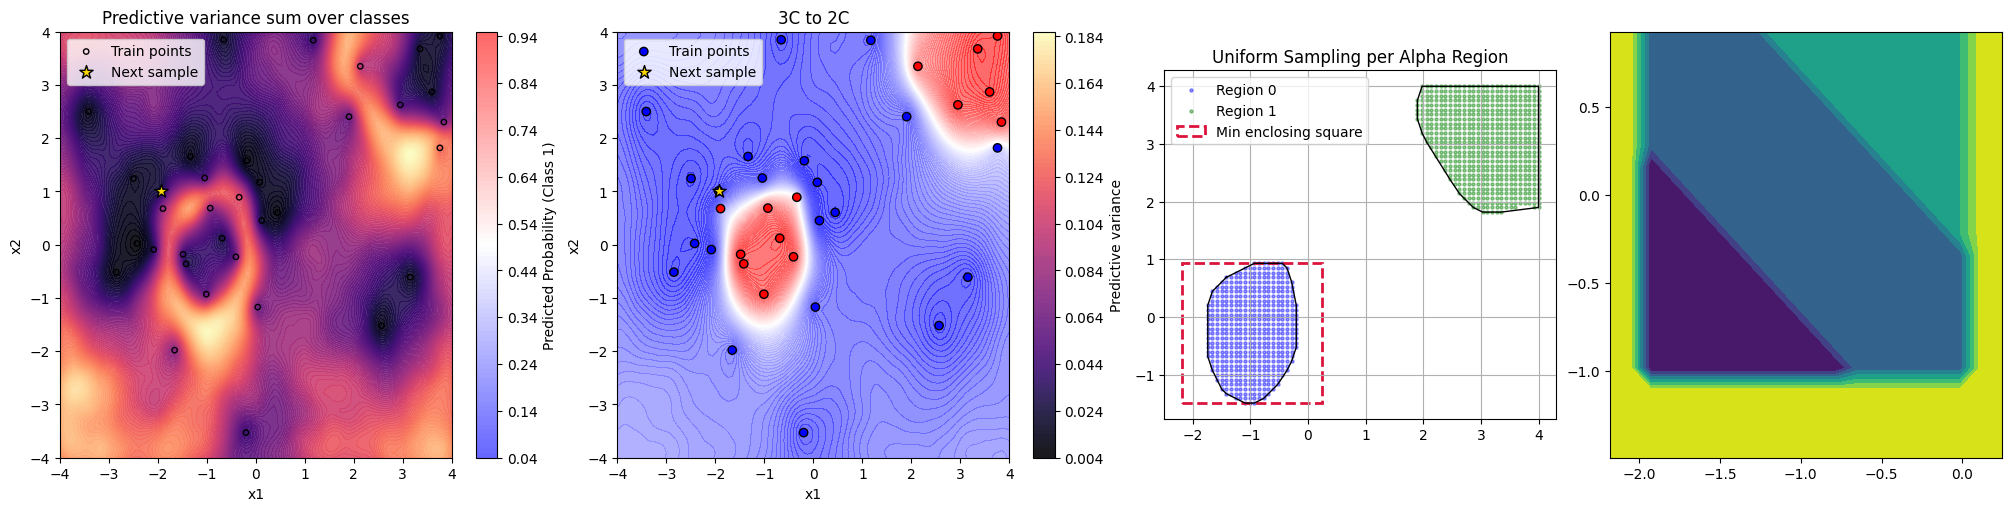

total_entropy - previous_total_entropy = 0.03813016941925986
Iter 1/50 - Loss: 2.970   lengthscale: 5.050   noise: 0.693
Iter 6/50 - Loss: 2.811   lengthscale: 4.733   noise: 0.972
Iter 11/50 - Loss: 2.703   lengthscale: 4.371   noise: 1.291
Iter 16/50 - Loss: 2.636   lengthscale: 3.984   noise: 1.606
Iter 21/50 - Loss: 2.597   lengthscale: 3.635   noise: 1.869
Iter 26/50 - Loss: 2.572   lengthscale: 3.341   noise: 2.057
Iter 31/50 - Loss: 2.553   lengthscale: 3.102   noise: 2.168
Iter 36/50 - Loss: 2.539   lengthscale: 2.924   noise: 2.216
Iter 41/50 - Loss: 2.528   lengthscale: 2.795   noise: 2.220
Iter 46/50 - Loss: 2.520   lengthscale: 2.682   noise: 2.195
tensor([-1.1611,  0.5465]) tensor(1) number of classes =  4


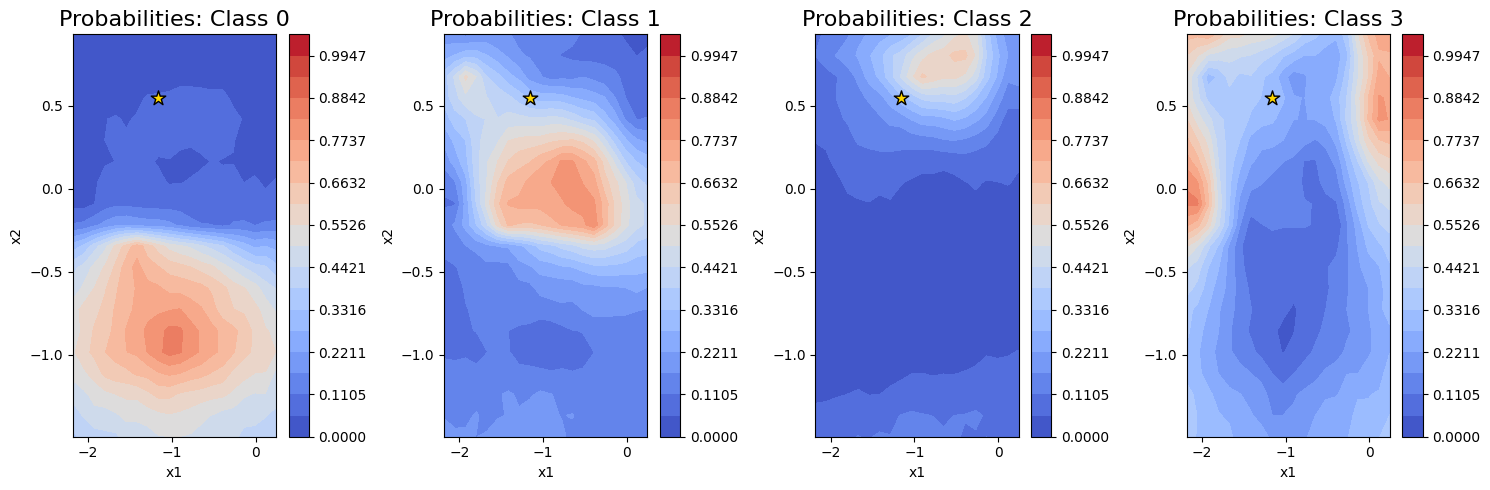

Iter 1/50 - Loss: 3.319   lengthscale: 0.693   noise: 0.693
Iter 6/50 - Loss: 2.983   lengthscale: 0.968   noise: 0.971
Iter 11/50 - Loss: 2.794   lengthscale: 1.248   noise: 1.300
Iter 16/50 - Loss: 2.688   lengthscale: 1.473   noise: 1.666
Iter 21/50 - Loss: 2.628   lengthscale: 1.619   noise: 2.039
Iter 26/50 - Loss: 2.592   lengthscale: 1.693   noise: 2.374
Iter 31/50 - Loss: 2.570   lengthscale: 1.715   noise: 2.633
Iter 36/50 - Loss: 2.555   lengthscale: 1.701   noise: 2.799
Iter 41/50 - Loss: 2.544   lengthscale: 1.667   noise: 2.876
Iter 46/50 - Loss: 2.535   lengthscale: 1.622   noise: 2.879


Detected 2 regions


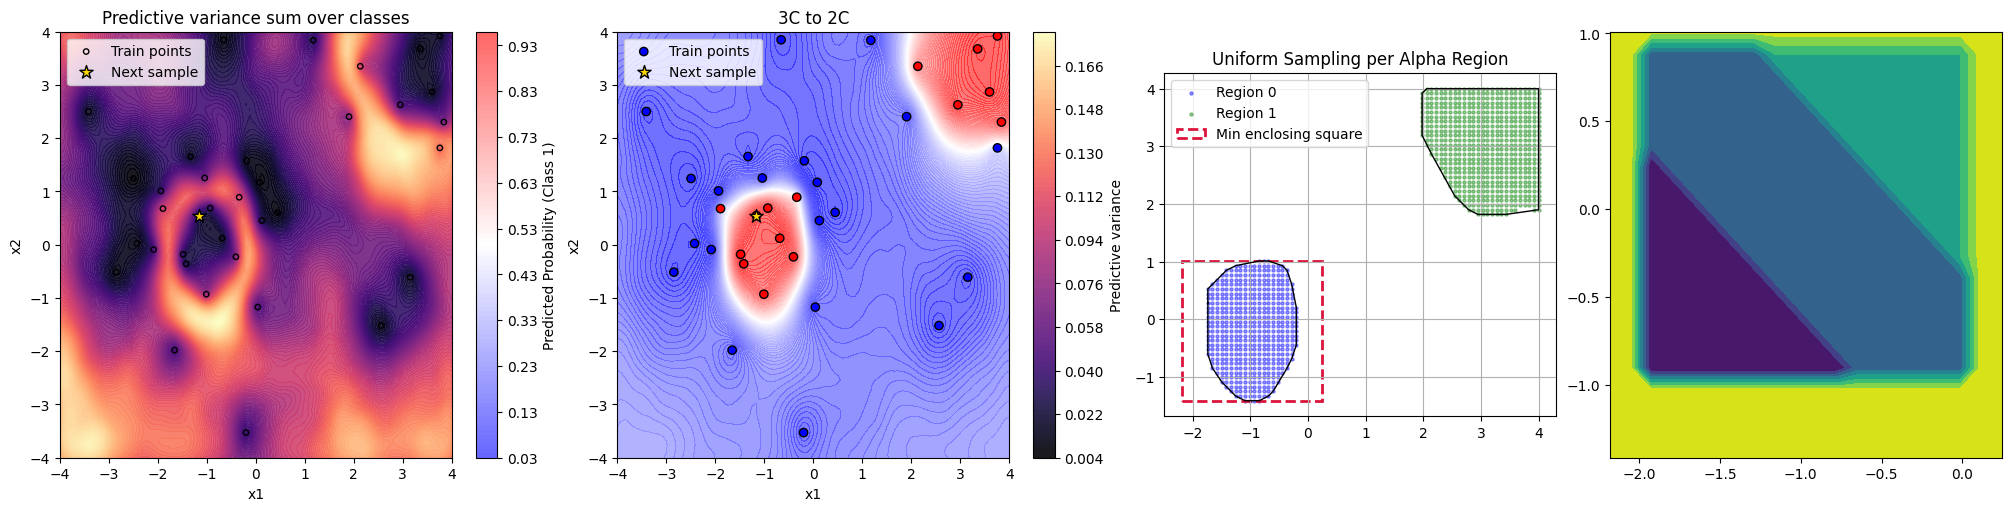

total_entropy - previous_total_entropy = 0.006708931939532756
Iter 1/50 - Loss: 2.953   lengthscale: 5.050   noise: 0.693
Iter 6/50 - Loss: 2.797   lengthscale: 4.712   noise: 0.972
Iter 11/50 - Loss: 2.690   lengthscale: 4.251   noise: 1.289
Iter 16/50 - Loss: 2.622   lengthscale: 3.794   noise: 1.597
Iter 21/50 - Loss: 2.582   lengthscale: 3.429   noise: 1.848
Iter 26/50 - Loss: 2.557   lengthscale: 3.178   noise: 2.015
Iter 31/50 - Loss: 2.540   lengthscale: 3.035   noise: 2.105
Iter 36/50 - Loss: 2.527   lengthscale: 2.970   noise: 2.135
Iter 41/50 - Loss: 2.516   lengthscale: 2.938   noise: 2.126
Iter 46/50 - Loss: 2.509   lengthscale: 2.907   noise: 2.095
tensor([ 0.2424, -0.3934]) tensor(3) number of classes =  4


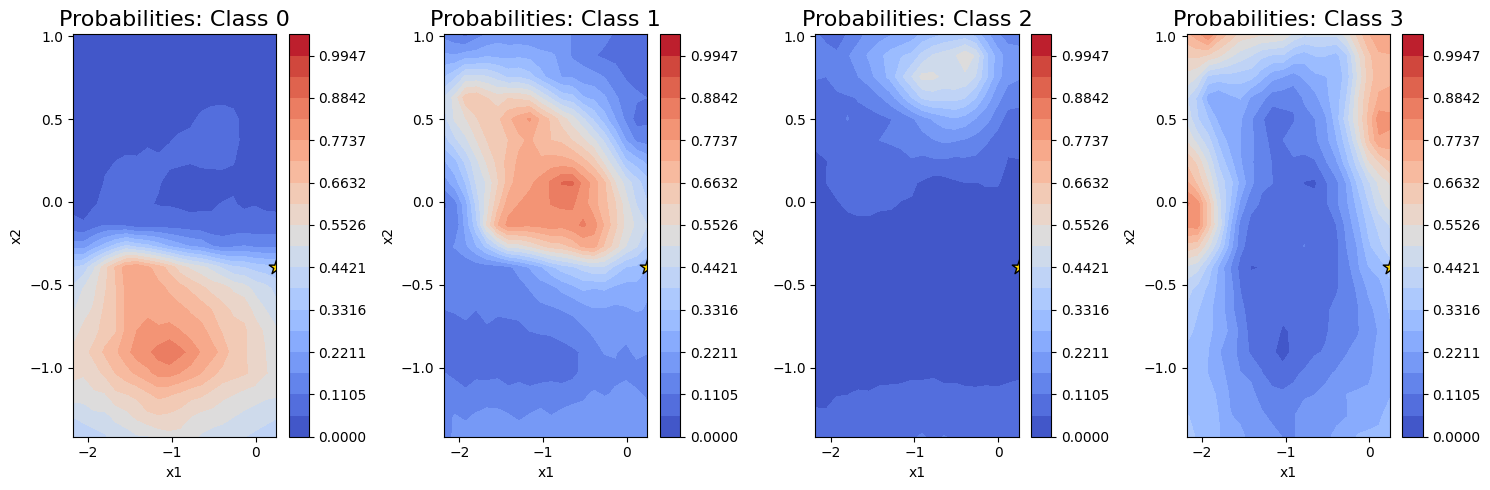

Iter 1/50 - Loss: 3.315   lengthscale: 0.693   noise: 0.693
Iter 6/50 - Loss: 2.980   lengthscale: 0.967   noise: 0.971
Iter 11/50 - Loss: 2.790   lengthscale: 1.242   noise: 1.299
Iter 16/50 - Loss: 2.683   lengthscale: 1.456   noise: 1.664
Iter 21/50 - Loss: 2.622   lengthscale: 1.594   noise: 2.027
Iter 26/50 - Loss: 2.585   lengthscale: 1.666   noise: 2.334
Iter 31/50 - Loss: 2.562   lengthscale: 1.690   noise: 2.545
Iter 36/50 - Loss: 2.547   lengthscale: 1.683   noise: 2.656
Iter 41/50 - Loss: 2.535   lengthscale: 1.656   noise: 2.682
Iter 46/50 - Loss: 2.525   lengthscale: 1.618   noise: 2.645
Detected 2 regions


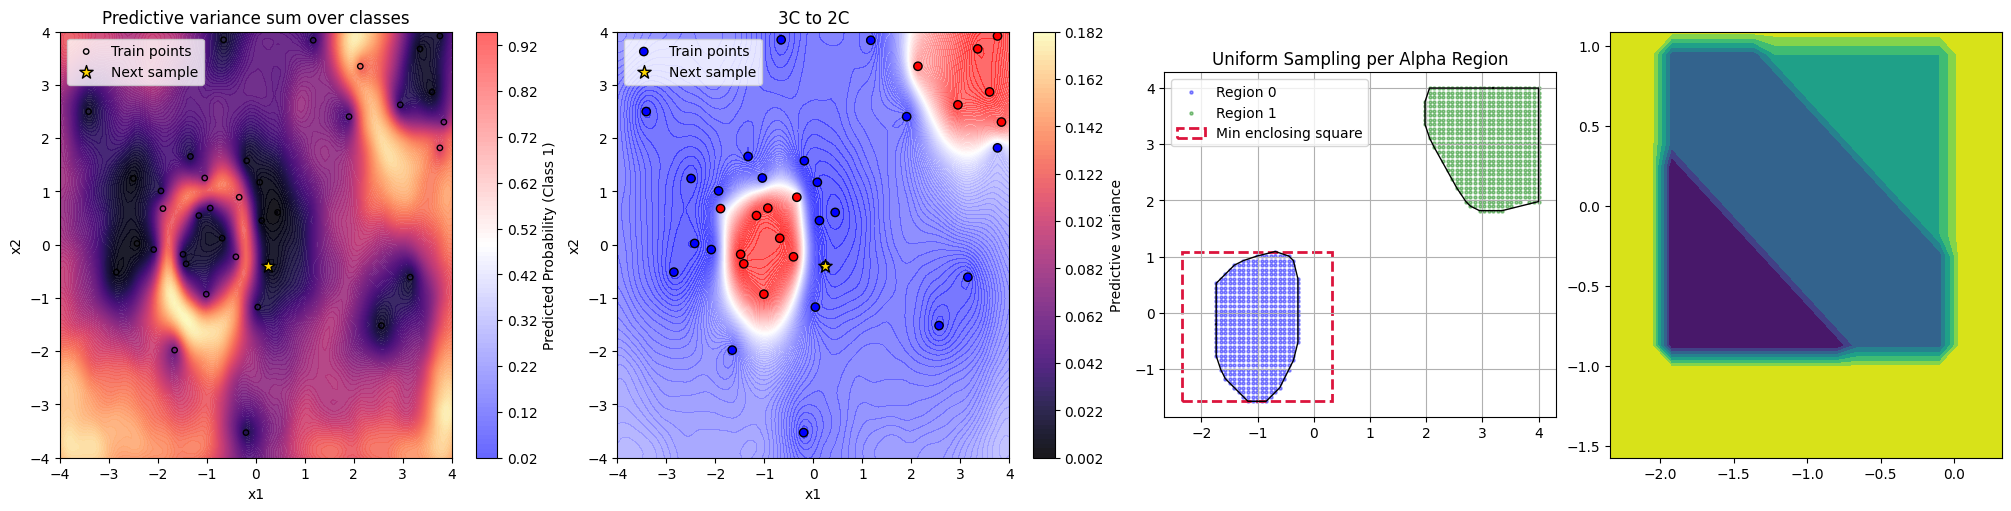

total_entropy - previous_total_entropy = 0.01721900922698768


In [63]:
# not to overwrite original data
train_x_3c = train_x_3c_o
train_y_3c = train_y_3c_o

train_x_2c = train_x_2c_o
train_y_2c = train_x_2c_o

training_iter = 50

func = "variance"
var_space = "prob"


nu = 0.5
initial_lengthscale = None
lengthscale_constraint = Interval(0.1,10)
outputscale_constraint = Interval(0.1,10)

previous_total_entropy = None
N=0

print(f"Initial train_x size : {len(train_x_3c)}")
for iteration in range(20):

    model, likelihood = run_sweeps(train_x_3c, train_y_3c, training_iter, 
                                   lr=lr, nu=nu, initial_lengthscale=initial_lengthscale, lengthscale_constraint=lengthscale_constraint, 
                                    outputscale_constraint=outputscale_constraint)
    
    # model, likelihood = run_sweeps(train_x_2c, train_y_2c, training_iter, lr=lr)
    probs, var, uncertainty, query_idx, total_entropy = acquisition(model, test_x_3c, func, var_space, num_samples)

    x_next = test_x_3c[query_idx]
    y_next = torch.tensor(black_box_3c(x_next[0], x_next[1]))
    y_next = torch.round(y_next).long().squeeze()
    num_classes = likelihood.num_classes
    print(x_next, y_next, "number of classes = ",likelihood.num_classes)

    # Append Data
    train_x_3c = torch.cat([train_x_3c, x_next.unsqueeze(0)], dim=0)
    train_y_3c = torch.cat([train_y_3c, y_next.unsqueeze(0)], dim=0)

    train_x_2c = torch.cat([train_x_2c, x_next.unsqueeze(0)], dim=0)

    # Visualization
    fig, ax = plt.subplots(1, num_classes, figsize=(15, 5))
    levels = np.linspace(0, 1.05, 20)

    for i in range(num_classes):
        im = ax[i].contourf(
            test_x1_3c.numpy(), test_x2_3c.numpy(),
            probs[i, :].view(test_x1_3c.shape[0], test_x2_3c.shape[1]).numpy(),
            levels=levels, cmap="coolwarm"
        )
        fig.colorbar(im, ax=ax[i])
        ax[i].set_title(f"Probabilities: Class {i}", fontsize=16)
        ax[i].set_xlabel("x1")
        ax[i].set_ylabel("x2")
        
        # Star = Next point for analysis 
        ax[i].scatter(x_next[0].item(), x_next[1].item(), c='gold', edgecolors='black', s=120, marker='*', label="Next sample")
        
    plt.tight_layout()
    plt.show()


    # # 2C classification

    train_y_3cto2c = torch.tensor([black_box_2C(x) for x in train_x_2c], dtype=torch.long)
    model, likelihood = run_sweeps(train_x_2c, train_y_3cto2c, training_iter, lr=lr)

    func = "most_unprobable"
    probs, var, uncertainty, query_idx, total_entropy = acquisition(model, test_x_2c, func, var_space, num_samples)
    # probs, var, uncertainty, query_idx = acquisition(model, test_x_2c, func, var_space, num_samples)

    fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharex=False, sharey=False,
                        constrained_layout=True)
    
    contour_var = axs[0].contourf(
    test_x1_2c.numpy(), test_x2_2c.numpy(),
    var.view(100, 100).numpy(), cmap="magma", levels=100, alpha=0.9
    )
    axs[0].set_title("Predictive variance sum over classes")
    axs[0].set_xlabel("x1"); axs[0].set_ylabel("x2")
    axs[0].scatter(train_x_2c[:, 0], train_x_2c[:, 1], c='none', edgecolors='k', s=15, label="Train points")
    axs[0].scatter(x_next[0].item(), x_next[1].item(), c='gold', edgecolors='black', s=100, marker='*', label="Next sample")
    axs[0].figure.colorbar(contour_var, ax=axs[1], label="Predictive variance")
    axs[0].legend()
    contour = axs[1].contourf(
        test_x1_2c.numpy(), test_x2_2c.numpy(),
        probs[1, :].view(test_x1_2c.shape[0], test_x2_2c.shape[1]).numpy(), cmap="bwr", levels=100, alpha=0.6
    )
    fig.colorbar(contour, ax = axs[0], label="Predicted Probability (Class 1)")
    axs[1].scatter(train_x_2c[:, 0], train_x_2c[:, 1], c=train_y_3cto2c, cmap="bwr", edgecolors='k', label="Train points")
    axs[1].scatter(x_next[0].item(), x_next[1].item(), c='gold', edgecolors='black', s=100, marker='*', label="Next sample")
    axs[1].set_title(f"3C to 2C")
    axs[1].set_xlabel("x1")
    axs[1].set_ylabel("x2")
    axs[1].legend()
 
    ## Select area -> Classify trained data and entire data into 3 classes
    
    # # Select area and define boundaries
    alphas = define_boundaries(axs[2], probs, test_x_2c)

    # # define smallest square
    square_min_x1, square_max_x1, square_min_x2, square_max_x2 = smallest_square(alphas,i=0)
    w = square_max_x1 - square_min_x1
    h = square_max_x2 - square_min_x2
    rect = Rectangle((square_min_x1, square_min_x2), w, h,
                    fill=False, edgecolor='crimson', linewidth=2, linestyle='--',
                    label='Min enclosing square')
    axs[2].add_patch(rect)

    axs[2].set_aspect('equal', adjustable='box')  # 진짜 정사각형으로 보이게
    axs[2].legend()

    # # Classify the entire data into 3 classes
    non_use, non_use, test_x1_3c, test_x2_3c, test_x_3c, non_use = ClassifyTestData_2Dto3D(axs[3], train_x_3c, square_min_x1, square_max_x1, square_min_x2, square_max_x2, alphas,i=0)

    plt.show()

    if previous_total_entropy != None:
        diff = abs(total_entropy - previous_total_entropy) / previous_total_entropy
        print(f"total_entropy - previous_total_entropy = {diff}")
        if  diff < 0.05 : 
            N = N+1
        else : 
            N= 0

        if N>4 :
            break
        
    # final_lengthscale = model.covar_module.base_kernel.lengthscale.tolist()
    # final_outputscale = model.covar_module.outputscale.tolist()
    previous_total_entropy = total_entropy
    # initial_lengthscale = final_lengthscale
    # initial_outputscale = final_outputscale        
